<table>
  <tr>
    <td style="text-align: center;">
      <img src="https://www.ufpi.br/images/ufpi-icone1.png" alt="UFPI Logo" style="width: 100px; height: auto;">
    </td>
    <td style="text-align: left;">
      <h3>Universidade Federal do Piauí - UFPI</h3>
      <h3>Departamento de Computação/CNN</h3>
      <h3>Trabalho da Disciplina de Aprendizado de Máquina</h3>
      <h3>Professor: Vinicius Ponte Machado</h3>
    </td>
  </tr>
</table>

**Alunos**: Marcelo Pontes e Marcelo Rego  
**Objetivo**: realizar estudos de Redes Neurais utilizando o banco de dados de vidros  
**Repositório**: [Glass Identification)](https://archive.ics.uci.edu/dataset/42/glass+identification)

# **Introdução**

<p style='text-align: justify;'>
O propósito da pesquisa foi ...
</p>

# **Metodologia**
<p style='text-align: justify;'>
O estudo foi conduzido de forma abrangente, revisitando cada etapa várias vezes para avaliar, ajustar e validar as hipóteses propostas.
</p>

## Importar as bibliotecas

In [1]:
# Importando as bibliotecas necessárias
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
import sklearn.metrics as mt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Defir a qualidade das imagens

In [2]:
dpi = 300

## Baixar o arquivo 'glass.data' diretamente no Colab

In [3]:
# Baixar o arquivo 'glass.data' diretamente no Colab
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data -O glass.data

--2024-11-13 23:25:10--  https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘glass.data’

glass.data              [ <=>                ]  11.62K  --.-KB/s    in 0s      

2024-11-13 23:25:10 (106 MB/s) - ‘glass.data’ saved [11903]



## Definir a Classe

Foi criada a classe a ser utilizada para todo o projeto

In [4]:
# Tangente

class NnModel:
    def __init__(self, X: np.ndarray, y: np.ndarray, hidden_neurons: int = 32, output_neurons: int = 3):
        np.random.seed(8)
        self.X = X
        self.y = y
        self.hidden_neurons = hidden_neurons
        self.output_neurons = output_neurons
        self.input_neurons = X.shape[1]

        # Inicialização Xavier
        self.W1 = np.random.randn(self.input_neurons, self.hidden_neurons) / np.sqrt(self.input_neurons)
        self.B1 = np.zeros((1, self.hidden_neurons))
        self.W2 = np.random.randn(self.hidden_neurons, self.output_neurons) / np.sqrt(self.hidden_neurons)
        self.B2 = np.zeros((1, self.output_neurons))

    def forward(self, X: np.ndarray) -> np.ndarray:
        # Cálculo da primeira camada
        self.z1 = X.dot(self.W1) + self.B1
        self.f1 = np.tanh(self.z1)

        # Cálculo da camada de saída
        z2 = self.f1.dot(self.W2) + self.B2

        # Softmax na saída
        exp_values = np.exp(z2 - np.max(z2, axis=1, keepdims=True))  # Evitar overflow
        softmax = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        return softmax

    def loss(self, softmax, y_batch):
        # Cross-entropy loss
        correct_log_probs = -np.log(softmax[range(len(y_batch)), y_batch])
        data_loss = np.sum(correct_log_probs) / len(y_batch)
        return data_loss

    def backpropagation(self, softmax: np.ndarray, X_batch: np.ndarray, y_batch: np.ndarray, learning_rate: float) -> None:
        delta2 = np.copy(softmax)
        delta2[range(len(y_batch)), y_batch] -= 1
        dW2 = self.f1.T.dot(delta2) / len(y_batch)
        dB2 = np.sum(delta2, axis=0, keepdims=True) / len(y_batch)
        delta1 = delta2.dot(self.W2.T) * (1 - np.power(np.tanh(self.z1), 2))
        dW1 = X_batch.T.dot(delta1) / len(y_batch)
        dB1 = np.sum(delta1, axis=0, keepdims=True) / len(y_batch)

        # Atualização dos pesos e bias
        self.W1 -= learning_rate * dW1
        self.W2 -= learning_rate * dW2
        self.B1 -= learning_rate * dB1
        self.B2 -= learning_rate * dB2

    def fit(self, epochs: int, lr: float, batch_size: int):
        best_accuracy = 0  # Variável para armazenar a melhor acurácia
        best_epoch = 0     # Variável para armazenar o epoch da melhor acurácia
        num_samples = self.X.shape[0]

        for epoch in range(epochs):
            # Embaralha os dados no início de cada epoch
            indices = np.arange(num_samples)
            np.random.shuffle(indices)
            X_shuffled = self.X[indices]
            y_shuffled = self.y[indices]

            # Variáveis para calcular acurácia e perda média por epoch
            epoch_loss = 0
            correct_predictions = 0

            # Iteração por batch
            for start in range(0, num_samples, batch_size):
                end = start + batch_size
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]

                # Passo de forward e cálculo da perda
                outputs = self.forward(X_batch)
                batch_loss = self.loss(outputs, y_batch)
                epoch_loss += batch_loss * len(y_batch)  # Soma da perda ponderada pelo tamanho do batch

                # Backpropagation
                self.backpropagation(outputs, X_batch, y_batch, lr)

                # Cálculo de acurácia do batch
                predictions = np.argmax(outputs, axis=1)
                correct_predictions += np.sum(predictions == y_batch)

            # Perda média e acurácia da época
            epoch_loss /= num_samples
            accuracy = correct_predictions / num_samples

            # Atualização da melhor acurácia
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_epoch = epoch + 1

            # Exibição periódica dos resultados
            if (epoch + 1) % (epochs // 10) == 0:
                print(f'Epoch: [{epoch + 1} / {epochs}]  Accuracy: {accuracy:.3f} Loss: {epoch_loss:.5f}')

        # Exibindo a melhor acurácia e o epoch correspondente
        print(f"\nMelhor Acurácia: {best_accuracy:.3f} no Epoch {best_epoch}")

        return best_accuracy

In [5]:
# ReLU
'''
import numpy as np

class NnModel:
    def __init__(self, X: np.ndarray, y: np.ndarray, hidden_neurons: int = 32, output_neurons: int = 3):
        np.random.seed(8)
        self.X = X
        self.y = y
        self.hidden_neurons = hidden_neurons
        self.output_neurons = output_neurons
        self.input_neurons = X.shape[1]

        # Inicialização Xavier
        self.W1 = np.random.randn(self.input_neurons, self.hidden_neurons) / np.sqrt(self.input_neurons)
        self.B1 = np.zeros((1, self.hidden_neurons))
        self.W2 = np.random.randn(self.hidden_neurons, self.output_neurons) / np.sqrt(self.hidden_neurons)
        self.B2 = np.zeros((1, self.output_neurons))

    def forward(self, X: np.ndarray) -> np.ndarray:
        # Cálculo da primeira camada com ReLU
        self.z1 = X.dot(self.W1) + self.B1
        self.f1 = np.maximum(0, self.z1)  # ReLU

        # Cálculo da camada de saída
        z2 = self.f1.dot(self.W2) + self.B2

        # Softmax na saída
        exp_values = np.exp(z2 - np.max(z2, axis=1, keepdims=True))  # Evitar overflow
        softmax = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        return softmax

    def loss(self, softmax, y_batch):
        # Cross-entropy loss
        correct_log_probs = -np.log(softmax[range(len(y_batch)), y_batch])
        data_loss = np.sum(correct_log_probs) / len(y_batch)
        return data_loss

    def backpropagation(self, softmax: np.ndarray, X_batch: np.ndarray, y_batch: np.ndarray, learning_rate: float) -> None:
        delta2 = np.copy(softmax)
        delta2[range(len(y_batch)), y_batch] -= 1
        dW2 = self.f1.T.dot(delta2) / len(y_batch)
        dB2 = np.sum(delta2, axis=0, keepdims=True) / len(y_batch)

        # Derivada de ReLU: 1 para valores positivos de z1 e 0 para valores <= 0
        delta1 = delta2.dot(self.W2.T) * (self.z1 > 0)
        dW1 = X_batch.T.dot(delta1) / len(y_batch)
        dB1 = np.sum(delta1, axis=0, keepdims=True) / len(y_batch)

        # Atualização dos pesos e bias
        self.W1 -= learning_rate * dW1
        self.W2 -= learning_rate * dW2
        self.B1 -= learning_rate * dB1
        self.B2 -= learning_rate * dB2

    def fit(self, epochs: int, lr: float, batch_size: int):
        best_accuracy = 0  # Variável para armazenar a melhor acurácia
        best_epoch = 0     # Variável para armazenar o epoch da melhor acurácia
        num_samples = self.X.shape[0]

        for epoch in range(epochs):
            # Embaralha os dados no início de cada epoch
            indices = np.arange(num_samples)
            np.random.shuffle(indices)
            X_shuffled = self.X[indices]
            y_shuffled = self.y[indices]

            # Variáveis para calcular acurácia e perda média por epoch
            epoch_loss = 0
            correct_predictions = 0

            # Iteração por batch
            for start in range(0, num_samples, batch_size):
                end = start + batch_size
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]

                # Passo de forward e cálculo da perda
                outputs = self.forward(X_batch)
                batch_loss = self.loss(outputs, y_batch)
                epoch_loss += batch_loss * len(y_batch)  # Soma da perda ponderada pelo tamanho do batch

                # Backpropagation
                self.backpropagation(outputs, X_batch, y_batch, lr)

                # Cálculo de acurácia do batch
                predictions = np.argmax(outputs, axis=1)
                correct_predictions += np.sum(predictions == y_batch)

            # Perda média e acurácia da época
            epoch_loss /= num_samples
            accuracy = correct_predictions / num_samples

            # Atualização da melhor acurácia
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_epoch = epoch + 1

            # Exibição periódica dos resultados
            if (epoch + 1) % (epochs // 10) == 0:
                print(f'Epoch: [{epoch + 1} / {epochs}]  Accuracy: {accuracy:.3f} Loss: {epoch_loss:.5f}')

        # Exibindo a melhor acurácia e o epoch correspondente
        print(f"\nMelhor Acurácia: {best_accuracy:.3f} no Epoch {best_epoch}")

        return best_accuracy
'''

'\nimport numpy as np\n\nclass NnModel:\n    def __init__(self, X: np.ndarray, y: np.ndarray, hidden_neurons: int = 32, output_neurons: int = 3):\n        np.random.seed(8)\n        self.X = X\n        self.y = y\n        self.hidden_neurons = hidden_neurons\n        self.output_neurons = output_neurons\n        self.input_neurons = X.shape[1]\n\n        # Inicialização Xavier\n        self.W1 = np.random.randn(self.input_neurons, self.hidden_neurons) / np.sqrt(self.input_neurons)\n        self.B1 = np.zeros((1, self.hidden_neurons))\n        self.W2 = np.random.randn(self.hidden_neurons, self.output_neurons) / np.sqrt(self.hidden_neurons)\n        self.B2 = np.zeros((1, self.output_neurons))\n\n    def forward(self, X: np.ndarray) -> np.ndarray:\n        # Cálculo da primeira camada com ReLU\n        self.z1 = X.dot(self.W1) + self.B1\n        self.f1 = np.maximum(0, self.z1)  # ReLU\n\n        # Cálculo da camada de saída\n        z2 = self.f1.dot(self.W2) + self.B2\n\n        # Soft

In [6]:
# Sigmoidal
'''
import numpy as np

class NnModel:
    def __init__(self, X: np.ndarray, y: np.ndarray, hidden_neurons: int = 32, output_neurons: int = 3):
        np.random.seed(8)
        self.X = X
        self.y = y
        self.hidden_neurons = hidden_neurons
        self.output_neurons = output_neurons
        self.input_neurons = X.shape[1]

        # Inicialização Xavier
        self.W1 = np.random.randn(self.input_neurons, self.hidden_neurons) / np.sqrt(self.input_neurons)
        self.B1 = np.zeros((1, self.hidden_neurons))
        self.W2 = np.random.randn(self.hidden_neurons, self.output_neurons) / np.sqrt(self.hidden_neurons)
        self.B2 = np.zeros((1, self.output_neurons))

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sigmoid_derivative(self, z):
        # Derivada da sigmoide: sigmoid(z) * (1 - sigmoid(z))
        return self.sigmoid(z) * (1 - self.sigmoid(z))

    def forward(self, X: np.ndarray) -> np.ndarray:
        # Cálculo da primeira camada com sigmoide
        self.z1 = X.dot(self.W1) + self.B1
        self.f1 = self.sigmoid(self.z1)  # Sigmoid

        # Cálculo da camada de saída
        z2 = self.f1.dot(self.W2) + self.B2

        # Softmax na saída
        exp_values = np.exp(z2 - np.max(z2, axis=1, keepdims=True))  # Evitar overflow
        softmax = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        return softmax

    def loss(self, softmax, y_batch):
        # Cross-entropy loss
        correct_log_probs = -np.log(softmax[range(len(y_batch)), y_batch])
        data_loss = np.sum(correct_log_probs) / len(y_batch)
        return data_loss

    def backpropagation(self, softmax: np.ndarray, X_batch: np.ndarray, y_batch: np.ndarray, learning_rate: float) -> None:
        delta2 = np.copy(softmax)
        delta2[range(len(y_batch)), y_batch] -= 1
        dW2 = self.f1.T.dot(delta2) / len(y_batch)
        dB2 = np.sum(delta2, axis=0, keepdims=True) / len(y_batch)

        # Derivada de Sigmoid
        delta1 = delta2.dot(self.W2.T) * self.sigmoid_derivative(self.z1)
        dW1 = X_batch.T.dot(delta1) / len(y_batch)
        dB1 = np.sum(delta1, axis=0, keepdims=True) / len(y_batch)

        # Atualização dos pesos e bias
        self.W1 -= learning_rate * dW1
        self.W2 -= learning_rate * dW2
        self.B1 -= learning_rate * dB1
        self.B2 -= learning_rate * dB2

    def fit(self, epochs: int, lr: float, batch_size: int):
        best_accuracy = 0  # Variável para armazenar a melhor acurácia
        best_epoch = 0     # Variável para armazenar o epoch da melhor acurácia
        num_samples = self.X.shape[0]

        for epoch in range(epochs):
            # Embaralha os dados no início de cada epoch
            indices = np.arange(num_samples)
            np.random.shuffle(indices)
            X_shuffled = self.X[indices]
            y_shuffled = self.y[indices]

            # Variáveis para calcular acurácia e perda média por epoch
            epoch_loss = 0
            correct_predictions = 0

            # Iteração por batch
            for start in range(0, num_samples, batch_size):
                end = start + batch_size
                X_batch = X_shuffled[start:end]
                y_batch = y_shuffled[start:end]

                # Passo de forward e cálculo da perda
                outputs = self.forward(X_batch)
                batch_loss = self.loss(outputs, y_batch)
                epoch_loss += batch_loss * len(y_batch)  # Soma da perda ponderada pelo tamanho do batch

                # Backpropagation
                self.backpropagation(outputs, X_batch, y_batch, lr)

                # Cálculo de acurácia do batch
                predictions = np.argmax(outputs, axis=1)
                correct_predictions += np.sum(predictions == y_batch)

            # Perda média e acurácia da época
            epoch_loss /= num_samples
            accuracy = correct_predictions / num_samples

            # Atualização da melhor acurácia
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_epoch = epoch + 1

            # Exibição periódica dos resultados
            if (epoch + 1) % (epochs // 10) == 0:
                print(f'Epoch: [{epoch + 1} / {epochs}]  Accuracy: {accuracy:.3f} Loss: {epoch_loss:.5f}')

        # Exibindo a melhor acurácia e o epoch correspondente
        print(f"\nMelhor Acurácia: {best_accuracy:.3f} no Epoch {best_epoch}")

        return best_accuracy
        '''

'\nimport numpy as np\n\nclass NnModel:\n    def __init__(self, X: np.ndarray, y: np.ndarray, hidden_neurons: int = 32, output_neurons: int = 3):\n        np.random.seed(8)\n        self.X = X\n        self.y = y\n        self.hidden_neurons = hidden_neurons\n        self.output_neurons = output_neurons\n        self.input_neurons = X.shape[1]\n\n        # Inicialização Xavier\n        self.W1 = np.random.randn(self.input_neurons, self.hidden_neurons) / np.sqrt(self.input_neurons)\n        self.B1 = np.zeros((1, self.hidden_neurons))\n        self.W2 = np.random.randn(self.hidden_neurons, self.output_neurons) / np.sqrt(self.hidden_neurons)\n        self.B2 = np.zeros((1, self.output_neurons))\n\n    def sigmoid(self, z):\n        return 1 / (1 + np.exp(-z))\n\n    def sigmoid_derivative(self, z):\n        # Derivada da sigmoide: sigmoid(z) * (1 - sigmoid(z))\n        return self.sigmoid(z) * (1 - self.sigmoid(z))\n\n    def forward(self, X: np.ndarray) -> np.ndarray:\n        # Cálculo

## **Hipótese 1 - Com Todas as Classes**

### Definindo os nomes das colunas

In [7]:
column_names = ["Id", "RI", "Na", "Mg", "Al", "Si", "K", "Ca", "Ba", "Fe", "Tipo"]
df = pd.read_csv('glass.data', names=column_names, index_col="Id")

### Visualizar os dados

In [8]:
df.keys()

Index(['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Tipo'], dtype='object')

In [9]:
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Tipo
Id,,,,,,,,,,
1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [10]:
df.describe().head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Tipo
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000


### Gerando a matriz de correlação

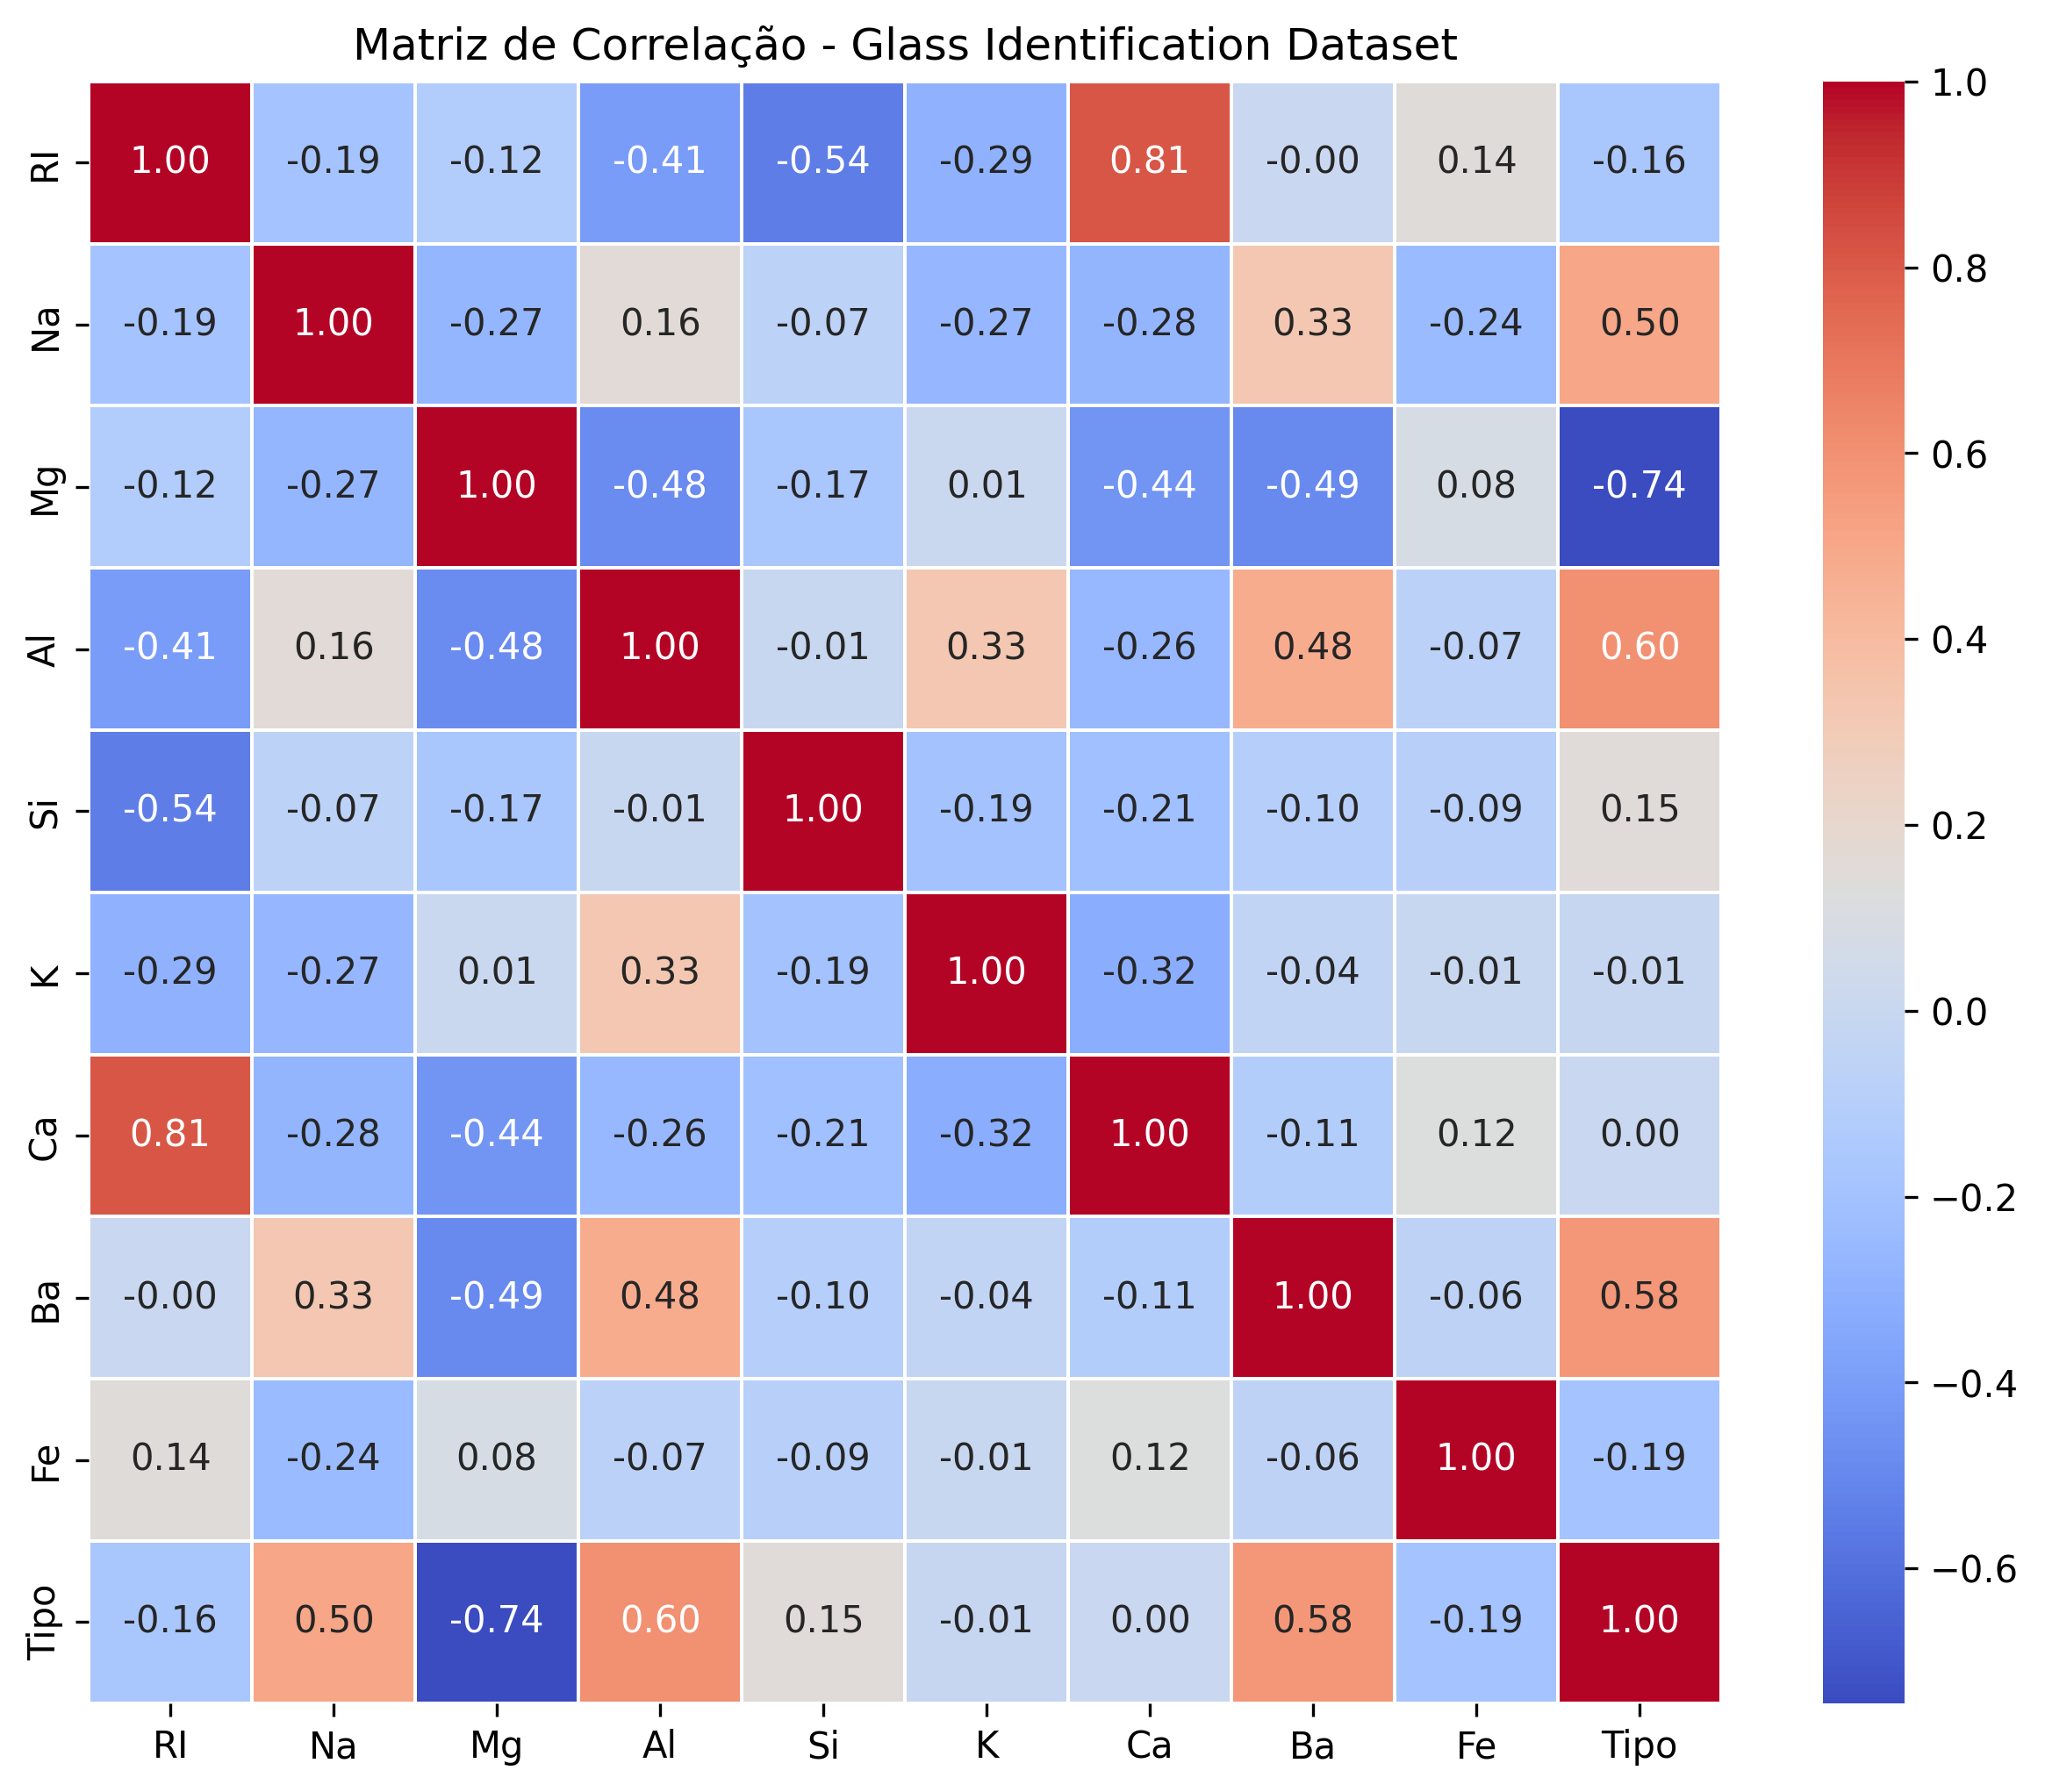

In [11]:
correlation_matrix = df.corr(numeric_only=True)

# Exibindo a matriz de correlação
plt.figure(figsize=(10, 8), dpi=dpi)
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlação - Glass Identification Dataset")
plt.show()

### Separando as variáveis

In [12]:
# Separando features e rótulos
X = df.drop('Tipo', axis=1).values  # Converte para NumPy diretamente
y = df['Tipo']

# Codificando as classes em valores numéricos
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Normalizando os dados
scaler = StandardScaler()
X = scaler.fit_transform(X)

### Dividir em treino e teste

In [13]:
# Dividindo os dados em treino e teste de forma balanceada (estratificada)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

### Treinar o Modelo

In [14]:
# Treinamento do modelo com os parâmetros especificados
model_7C = NnModel(X_train, y_train, hidden_neurons=32, output_neurons=7)
result_7C = model_7C.fit(epochs=800, lr=0.1, batch_size=10)

Epoch: [80 / 800]  Accuracy: 0.872 Loss: 0.35413
Epoch: [160 / 800]  Accuracy: 0.933 Loss: 0.22501
Epoch: [240 / 800]  Accuracy: 0.946 Loss: 0.16073
Epoch: [320 / 800]  Accuracy: 0.973 Loss: 0.11136
Epoch: [400 / 800]  Accuracy: 0.980 Loss: 0.07959
Epoch: [480 / 800]  Accuracy: 0.987 Loss: 0.05921
Epoch: [560 / 800]  Accuracy: 0.993 Loss: 0.04808
Epoch: [640 / 800]  Accuracy: 0.993 Loss: 0.03947
Epoch: [720 / 800]  Accuracy: 0.993 Loss: 0.03251
Epoch: [800 / 800]  Accuracy: 0.993 Loss: 0.02800

Melhor Acurácia: 1.000 no Epoch 585


### Relatório de Classificação no Conjunto de Teste

In [15]:
# Gerando previsões no conjunto de teste
outputs_test = model_7C.forward(X_test)
predictions_test = np.argmax(outputs_test, axis=1)

# Gerando o relatório de classificação
print("Relatório de Classificação no Conjunto de Teste:\n")
print(classification_report(y_test, predictions_test))

# Opcional: Exibir acurácia separadamente
accuracy_test = accuracy_score(y_test, predictions_test)
print(f"Acurácia no conjunto de teste: {accuracy_test:.4f}")

Relatório de Classificação no Conjunto de Teste:

              precision    recall  f1-score   support

           0       0.71      0.71      0.71        21
           1       0.69      0.78      0.73        23
           2       0.33      0.20      0.25         5
           3       1.00      0.25      0.40         4
           4       0.60      1.00      0.75         3
           5       1.00      1.00      1.00         9

    accuracy                           0.72        65
   macro avg       0.72      0.66      0.64        65
weighted avg       0.73      0.72      0.71        65

Acurácia no conjunto de teste: 0.7231


### Gerando a matriz de confusão

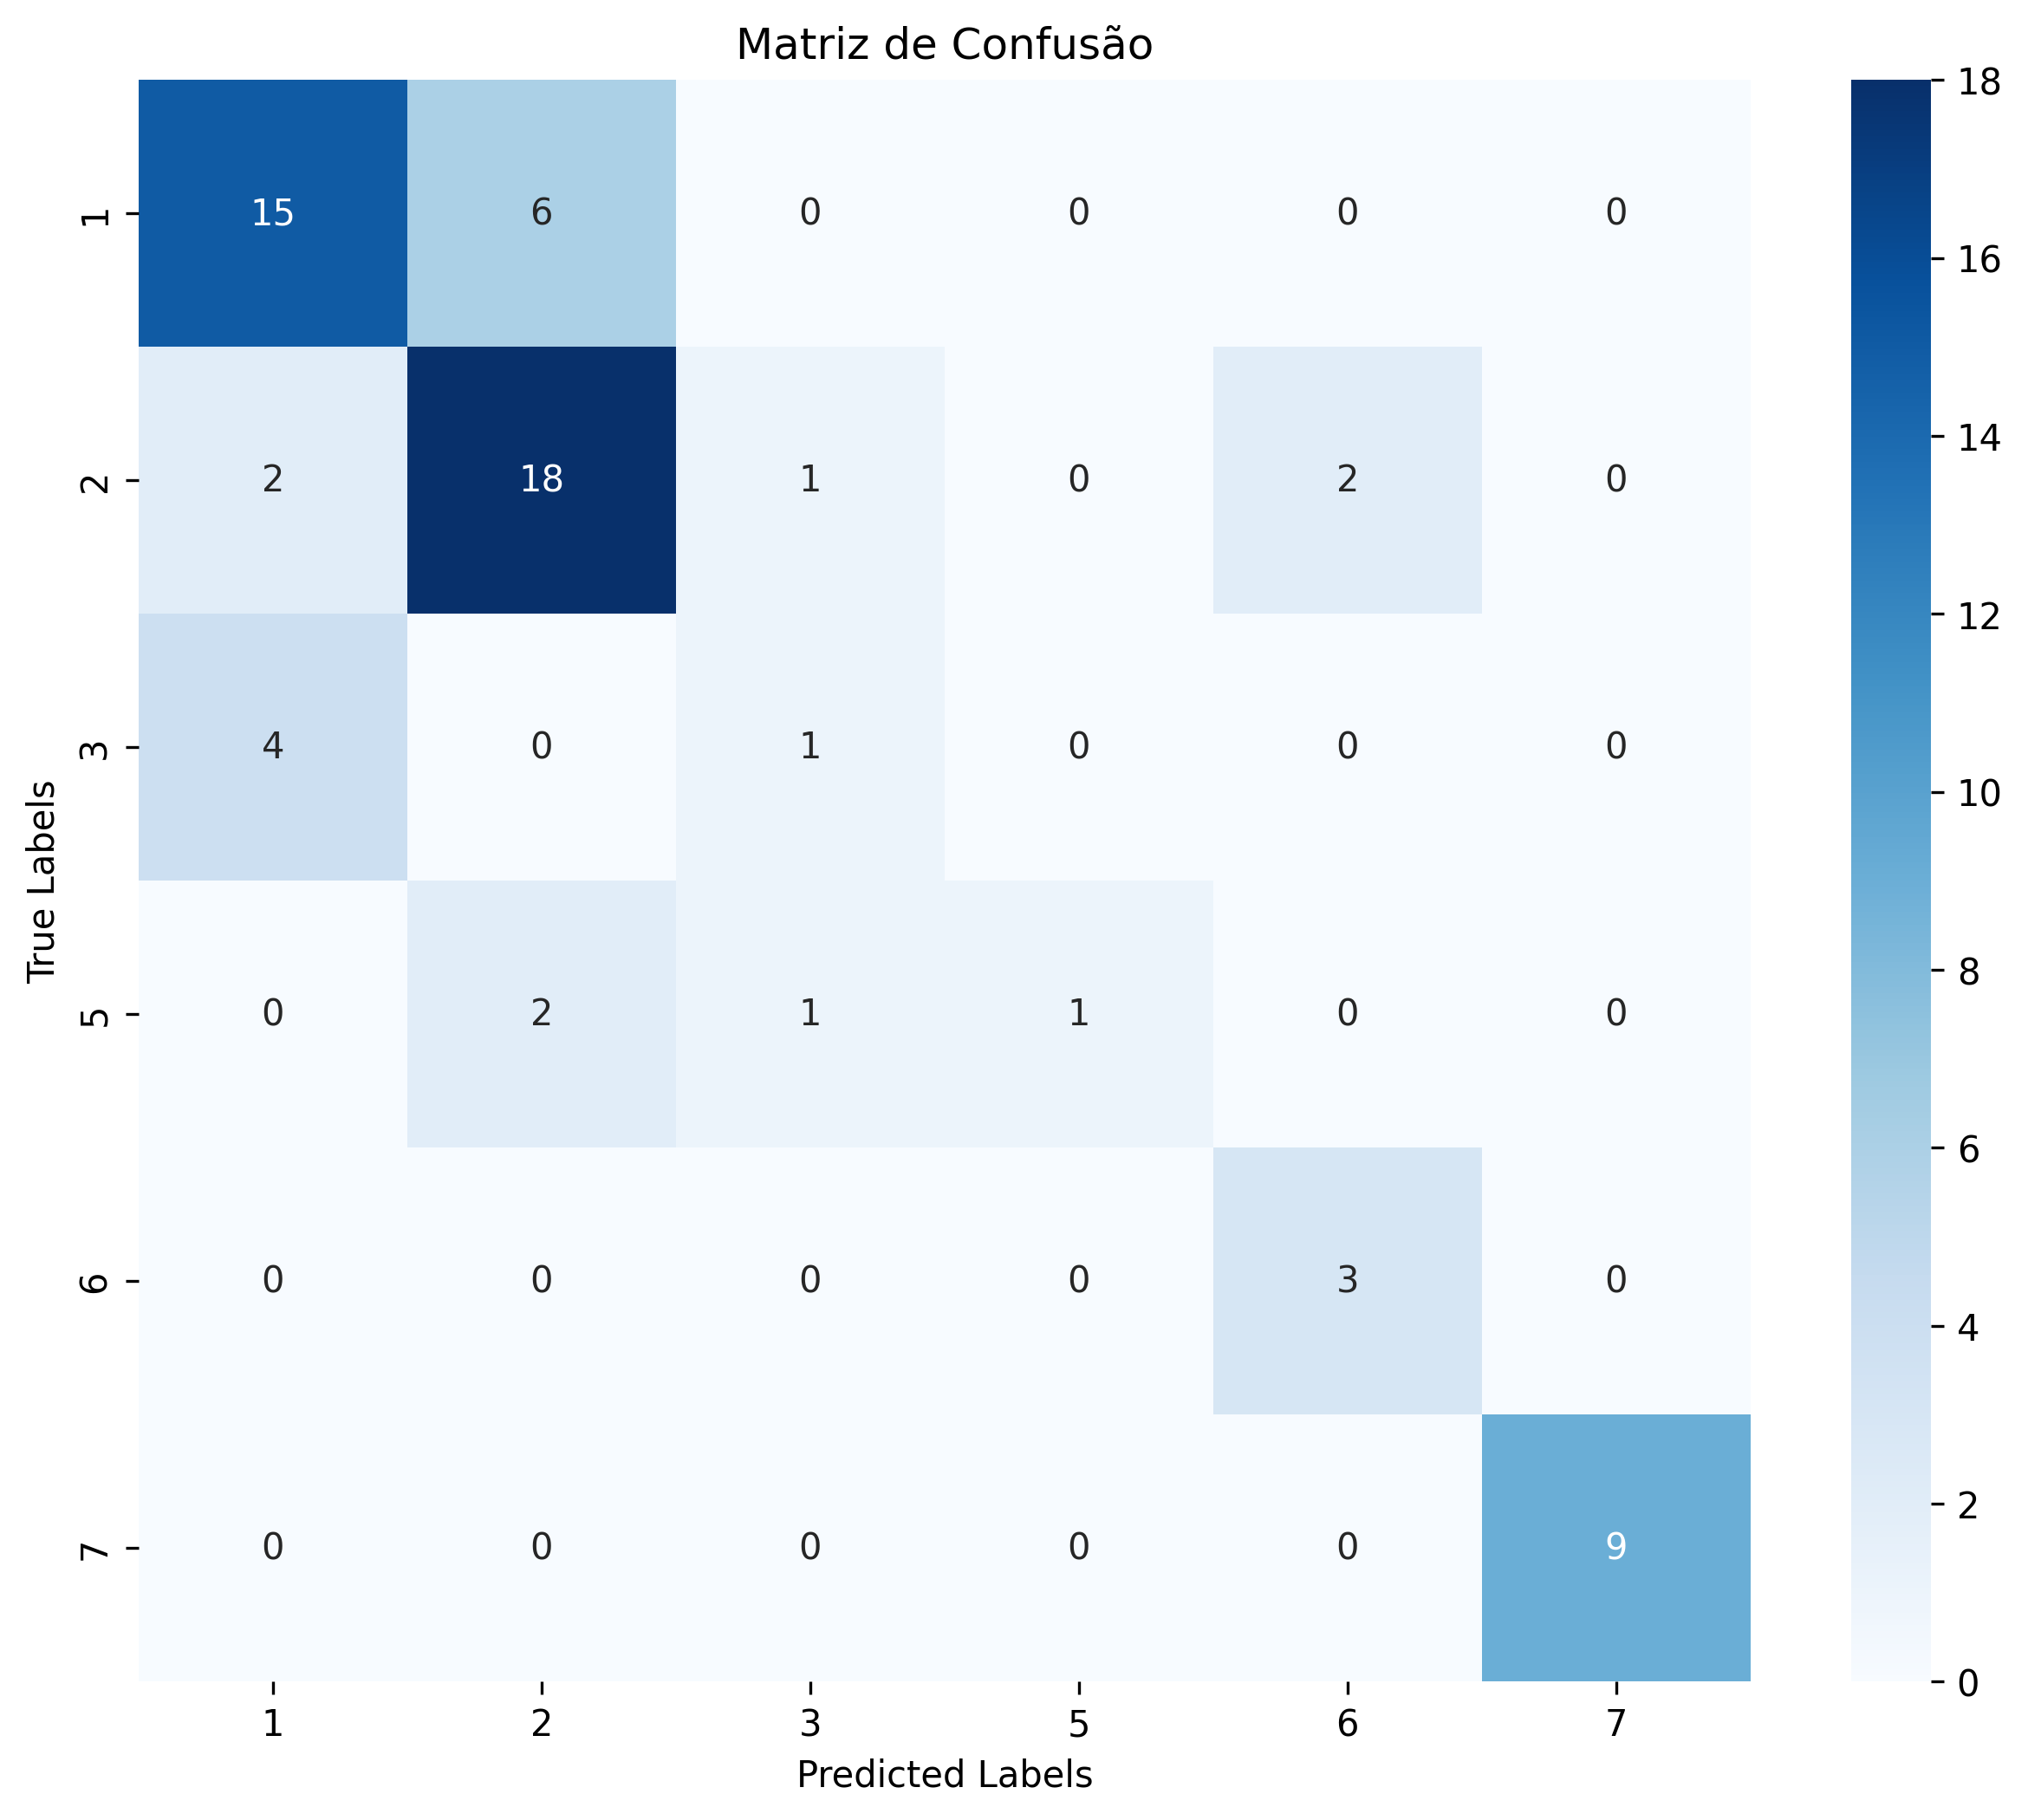

In [16]:
# Gerando a matriz de confusão
conf_matrix = confusion_matrix(y_test, predictions_test)

# Plotando a matriz de confusão
plt.figure(figsize=(10, 8), dpi=dpi)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Matriz de Confusão")
plt.show()

## Hipótese 2 - Com 3 Classes e Removendo o Ca

### Definindo os nomes das colunas

In [17]:
column_names = ["Id", "RI", "Na", "Mg", "Al", "Si", "K", "Ca", "Ba", "Fe", "Tipo"]
df = pd.read_csv('glass.data', names=column_names, index_col="Id")

### Separando as variáveis

In [18]:
# Mapeando as classes
df['Tipo'] = df['Tipo'].map({
    1: '1 - Vidro Flutuado',
    2: '2 - Vidro Não Flutuado',
    3: 'Outros', 4: 'Outros', 5: 'Outros', 6: 'Outros', 7: 'Outros'
})

In [19]:
# Separando features e rótulos
X = df.drop(['Tipo', 'Ca'], axis=1).values  # Converte para NumPy diretamente
y = df['Tipo']

In [20]:
# Codificando as classes em valores numéricos
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Normalizando os dados
scaler = StandardScaler()
X = scaler.fit_transform(X)

### Dividir em treino e teste

In [21]:
# Dividindo os dados em treino e teste de forma balanceada (estratificada)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

### Treinar o Modelo

In [22]:
# Treinamento do modelo com os parâmetros especificados
model_3C = NnModel(X_train, y_train, hidden_neurons=32, output_neurons=3)
result_3C = model_3C.fit(epochs=2000, lr=0.1, batch_size=10)

Epoch: [200 / 2000]  Accuracy: 0.906 Loss: 0.21555
Epoch: [400 / 2000]  Accuracy: 0.980 Loss: 0.08211
Epoch: [600 / 2000]  Accuracy: 1.000 Loss: 0.04317
Epoch: [800 / 2000]  Accuracy: 1.000 Loss: 0.02430
Epoch: [1000 / 2000]  Accuracy: 1.000 Loss: 0.01558
Epoch: [1200 / 2000]  Accuracy: 1.000 Loss: 0.01156
Epoch: [1400 / 2000]  Accuracy: 1.000 Loss: 0.00893
Epoch: [1600 / 2000]  Accuracy: 1.000 Loss: 0.00713
Epoch: [1800 / 2000]  Accuracy: 1.000 Loss: 0.00586
Epoch: [2000 / 2000]  Accuracy: 1.000 Loss: 0.00490

Melhor Acurácia: 1.000 no Epoch 458


### Relatório de Classificação no Conjunto de Teste

In [23]:
# Gerando previsões no conjunto de teste
outputs_test = model_3C.forward(X_test)
predictions_test = np.argmax(outputs_test, axis=1)

# Gerando o relatório de classificação
print("Relatório de Classificação no Conjunto de Teste:\n")
print(classification_report(y_test, predictions_test))

# Opcional: Exibir acurácia separadamente
accuracy_test = accuracy_score(y_test, predictions_test)
print(f"Acurácia no conjunto de teste: {accuracy_test:.4f}")

Relatório de Classificação no Conjunto de Teste:

              precision    recall  f1-score   support

           0       0.80      0.76      0.78        21
           1       0.73      0.70      0.71        23
           2       0.74      0.81      0.77        21

    accuracy                           0.75        65
   macro avg       0.76      0.76      0.75        65
weighted avg       0.75      0.75      0.75        65

Acurácia no conjunto de teste: 0.7538


### Gerando a matriz de confusão

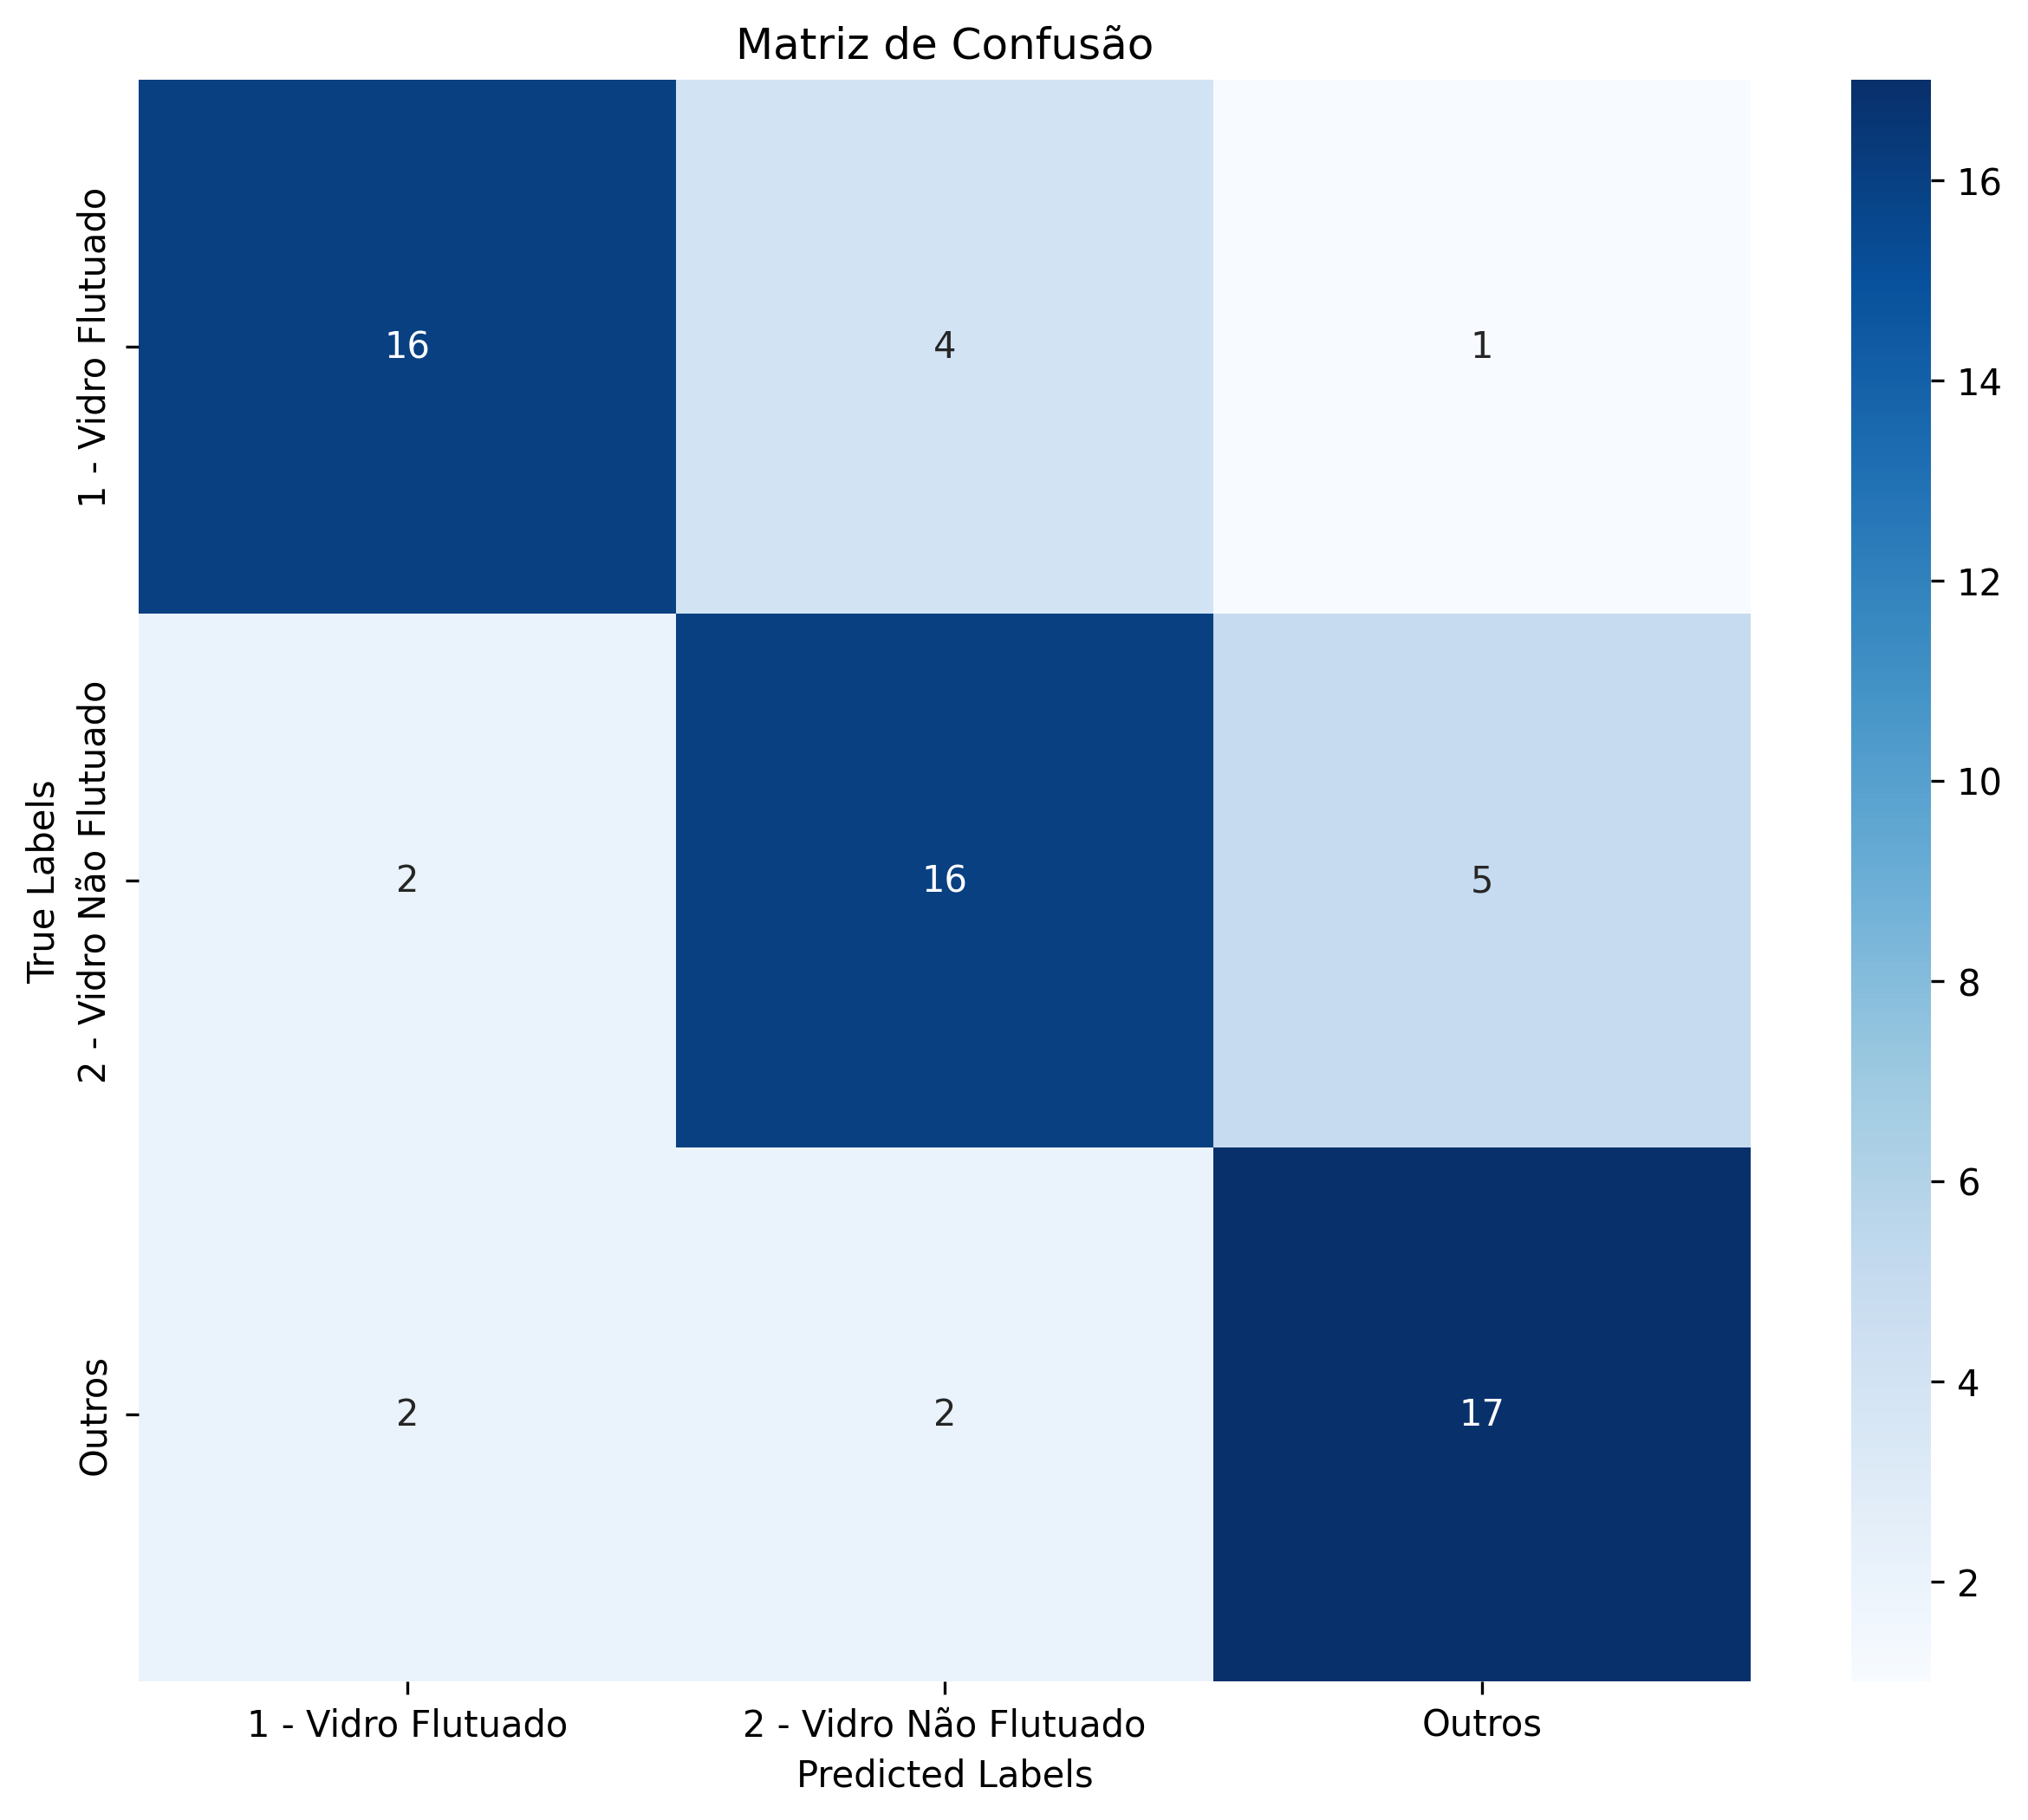

In [24]:
# Gerando a matriz de confusão
conf_matrix = confusion_matrix(y_test, predictions_test)

# Plotando a matriz de confusão
plt.figure(figsize=(10, 8), dpi=dpi)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Matriz de Confusão")
plt.show()

### Visualizar os resultados

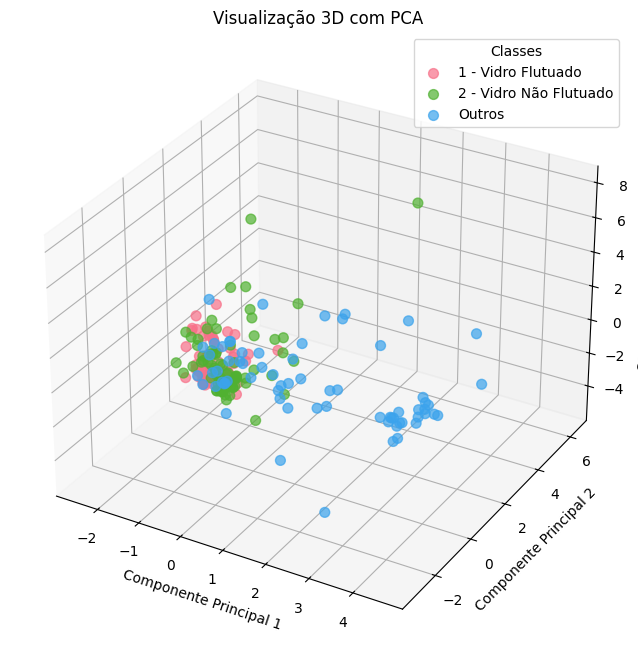

In [25]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Redução de dimensionalidade com PCA para 3 dimensões
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X)

# Mapeando cores para cada classe para visualização
colors = sns.color_palette("husl", len(encoder.classes_))
color_map = {i: colors[i] for i in range(len(colors))}

# Criando o gráfico 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Adicionando pontos ao gráfico
for class_label in np.unique(y):
    indices = y == class_label
    ax.scatter(
        X_pca_3d[indices, 0],
        X_pca_3d[indices, 1],
        X_pca_3d[indices, 2],
        color=color_map[class_label],
        label=encoder.inverse_transform([class_label])[0],
        alpha=0.7,
        s=50
    )

# Configurações do gráfico
ax.set_title("Visualização 3D com PCA")
ax.set_xlabel("Componente Principal 1")
ax.set_ylabel("Componente Principal 2")
ax.set_zlabel("Componente Principal 3")
plt.legend(title="Classes")
plt.show()

In [26]:
# Aplicando PCA para 3 componentes
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X)

# Calculando a variância explicada
explained_variance_ratio = pca_3d.explained_variance_ratio_
total_explained_variance = explained_variance_ratio.sum()

# Exibindo a variância explicada por cada componente e o total
print("Variância explicada por cada componente principal:")
for i, variance in enumerate(explained_variance_ratio, start=1):
    print(f"Componente Principal {i}: {variance:.2%}")

print(f"\nVariância total explicada pelas 3 primeiras componentes: {total_explained_variance:.2%}")

Variância explicada por cada componente principal:
Componente Principal 1: 28.13%
Componente Principal 2: 20.28%
Componente Principal 3: 17.56%

Variância total explicada pelas 3 primeiras componentes: 65.97%


In [27]:
# Calculando o PCA com 3 componentes principais
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X)

# Obtendo os autovalores
eigenvalues = pca_3d.explained_variance_

# Exibindo os autovalores de cada componente principal
print("Autovalores (variância explicada) de cada componente principal:")
for i, eigenvalue in enumerate(eigenvalues, start=1):
    print(f"Componente Principal {i}: {eigenvalue:.4f}")

Autovalores (variância explicada) de cada componente principal:
Componente Principal 1: 2.2613
Componente Principal 2: 1.6300
Componente Principal 3: 1.4114


## Hipótese 3 - Reduzir a 2 classes (exluir "outros")

In [28]:
column_names = ["Id", "RI", "Na", "Mg", "Al", "Si", "K", "Ca", "Ba", "Fe", "Tipo"]
df = pd.read_csv('glass.data', names=column_names, index_col="Id")

In [29]:
# Mapeando as classes
df['Tipo'] = df['Tipo'].map({
    1: '1 - Vidro Flutuado',
    2: '2 - Vidro não Flutuado',
    3: 'Outros', 4: 'Outros', 5: 'Outros', 6: 'Outros', 7: 'Outros'
})

In [30]:
# Verificando a contagem de valores únicos em 'Tipo' após o mapeamento
print("Contagem de valores únicos em 'Tipo' após o mapeamento:")
print(df['Tipo'].value_counts())

# Filtrando para manter apenas as linhas onde o 'Tipo' é '1 - Vidro Flutuado' ou '2 - Vidro Temperado'
df = df[df['Tipo'].isin(['1 - Vidro Flutuado', '2 - Vidro não Flutuado'])]

# Exibindo o DataFrame resultante após o filtro
print("\nDataFrame após remover as linhas com 'Outros':")
print(df)

Contagem de valores únicos em 'Tipo' após o mapeamento:
Tipo
2 - Vidro não Flutuado    76
1 - Vidro Flutuado        70
Outros                    68
Name: count, dtype: int64

DataFrame após remover as linhas com 'Outros':
          RI     Na    Mg    Al     Si     K    Ca    Ba    Fe  \
Id                                                               
1    1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.00  0.00   
2    1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.00  0.00   
3    1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.00  0.00   
4    1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.00  0.00   
5    1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.00  0.00   
..       ...    ...   ...   ...    ...   ...   ...   ...   ...   
142  1.51851  13.20  3.63  1.07  72.83  0.57  8.41  0.09  0.17   
143  1.51662  12.85  3.51  1.44  73.01  0.68  8.23  0.06  0.25   
144  1.51709  13.00  3.47  1.79  72.72  0.66  8.18  0.00  0.00   
145  1.51660  12.99  3.18  1.23  72.97  0.58  8.81  

In [31]:
# Separando features e rótulos
X = df.drop(['Tipo', 'Ca'], axis=1).values  # Converte para NumPy diretamente
y = df['Tipo']

In [32]:
# Codificando as classes em valores numéricos
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Normalizando os dados
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [33]:
# Dividindo os dados em treino e teste de forma balanceada (estratificada)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [34]:
# Treinamento do modelo com os parâmetros especificados
model_2C = NnModel(X_train, y_train, hidden_neurons=24, output_neurons=2)
result_2C = model_2C.fit(epochs=3000, lr=0.06, batch_size=20)

Epoch: [300 / 3000]  Accuracy: 0.882 Loss: 0.24690
Epoch: [600 / 3000]  Accuracy: 0.971 Loss: 0.09598
Epoch: [900 / 3000]  Accuracy: 0.990 Loss: 0.05683
Epoch: [1200 / 3000]  Accuracy: 1.000 Loss: 0.03238
Epoch: [1500 / 3000]  Accuracy: 1.000 Loss: 0.02054
Epoch: [1800 / 3000]  Accuracy: 1.000 Loss: 0.01500
Epoch: [2100 / 3000]  Accuracy: 1.000 Loss: 0.01132
Epoch: [2400 / 3000]  Accuracy: 1.000 Loss: 0.00893
Epoch: [2700 / 3000]  Accuracy: 1.000 Loss: 0.00748
Epoch: [3000 / 3000]  Accuracy: 1.000 Loss: 0.00633

Melhor Acurácia: 1.000 no Epoch 783


In [35]:
# Gerando previsões no conjunto de teste
outputs_test = model_2C.forward(X_test)
predictions_test = np.argmax(outputs_test, axis=1)

# Gerando o relatório de classificação
print("Relatório de Classificação no Conjunto de Teste:\n")
print(classification_report(y_test, predictions_test))

# Opcional: Exibir acurácia separadamente
accuracy_test = accuracy_score(y_test, predictions_test)
print(f"Acurácia no conjunto de teste: {accuracy_test:.4f}")

Relatório de Classificação no Conjunto de Teste:

              precision    recall  f1-score   support

           0       0.89      0.81      0.85        21
           1       0.84      0.91      0.88        23

    accuracy                           0.86        44
   macro avg       0.87      0.86      0.86        44
weighted avg       0.87      0.86      0.86        44

Acurácia no conjunto de teste: 0.8636


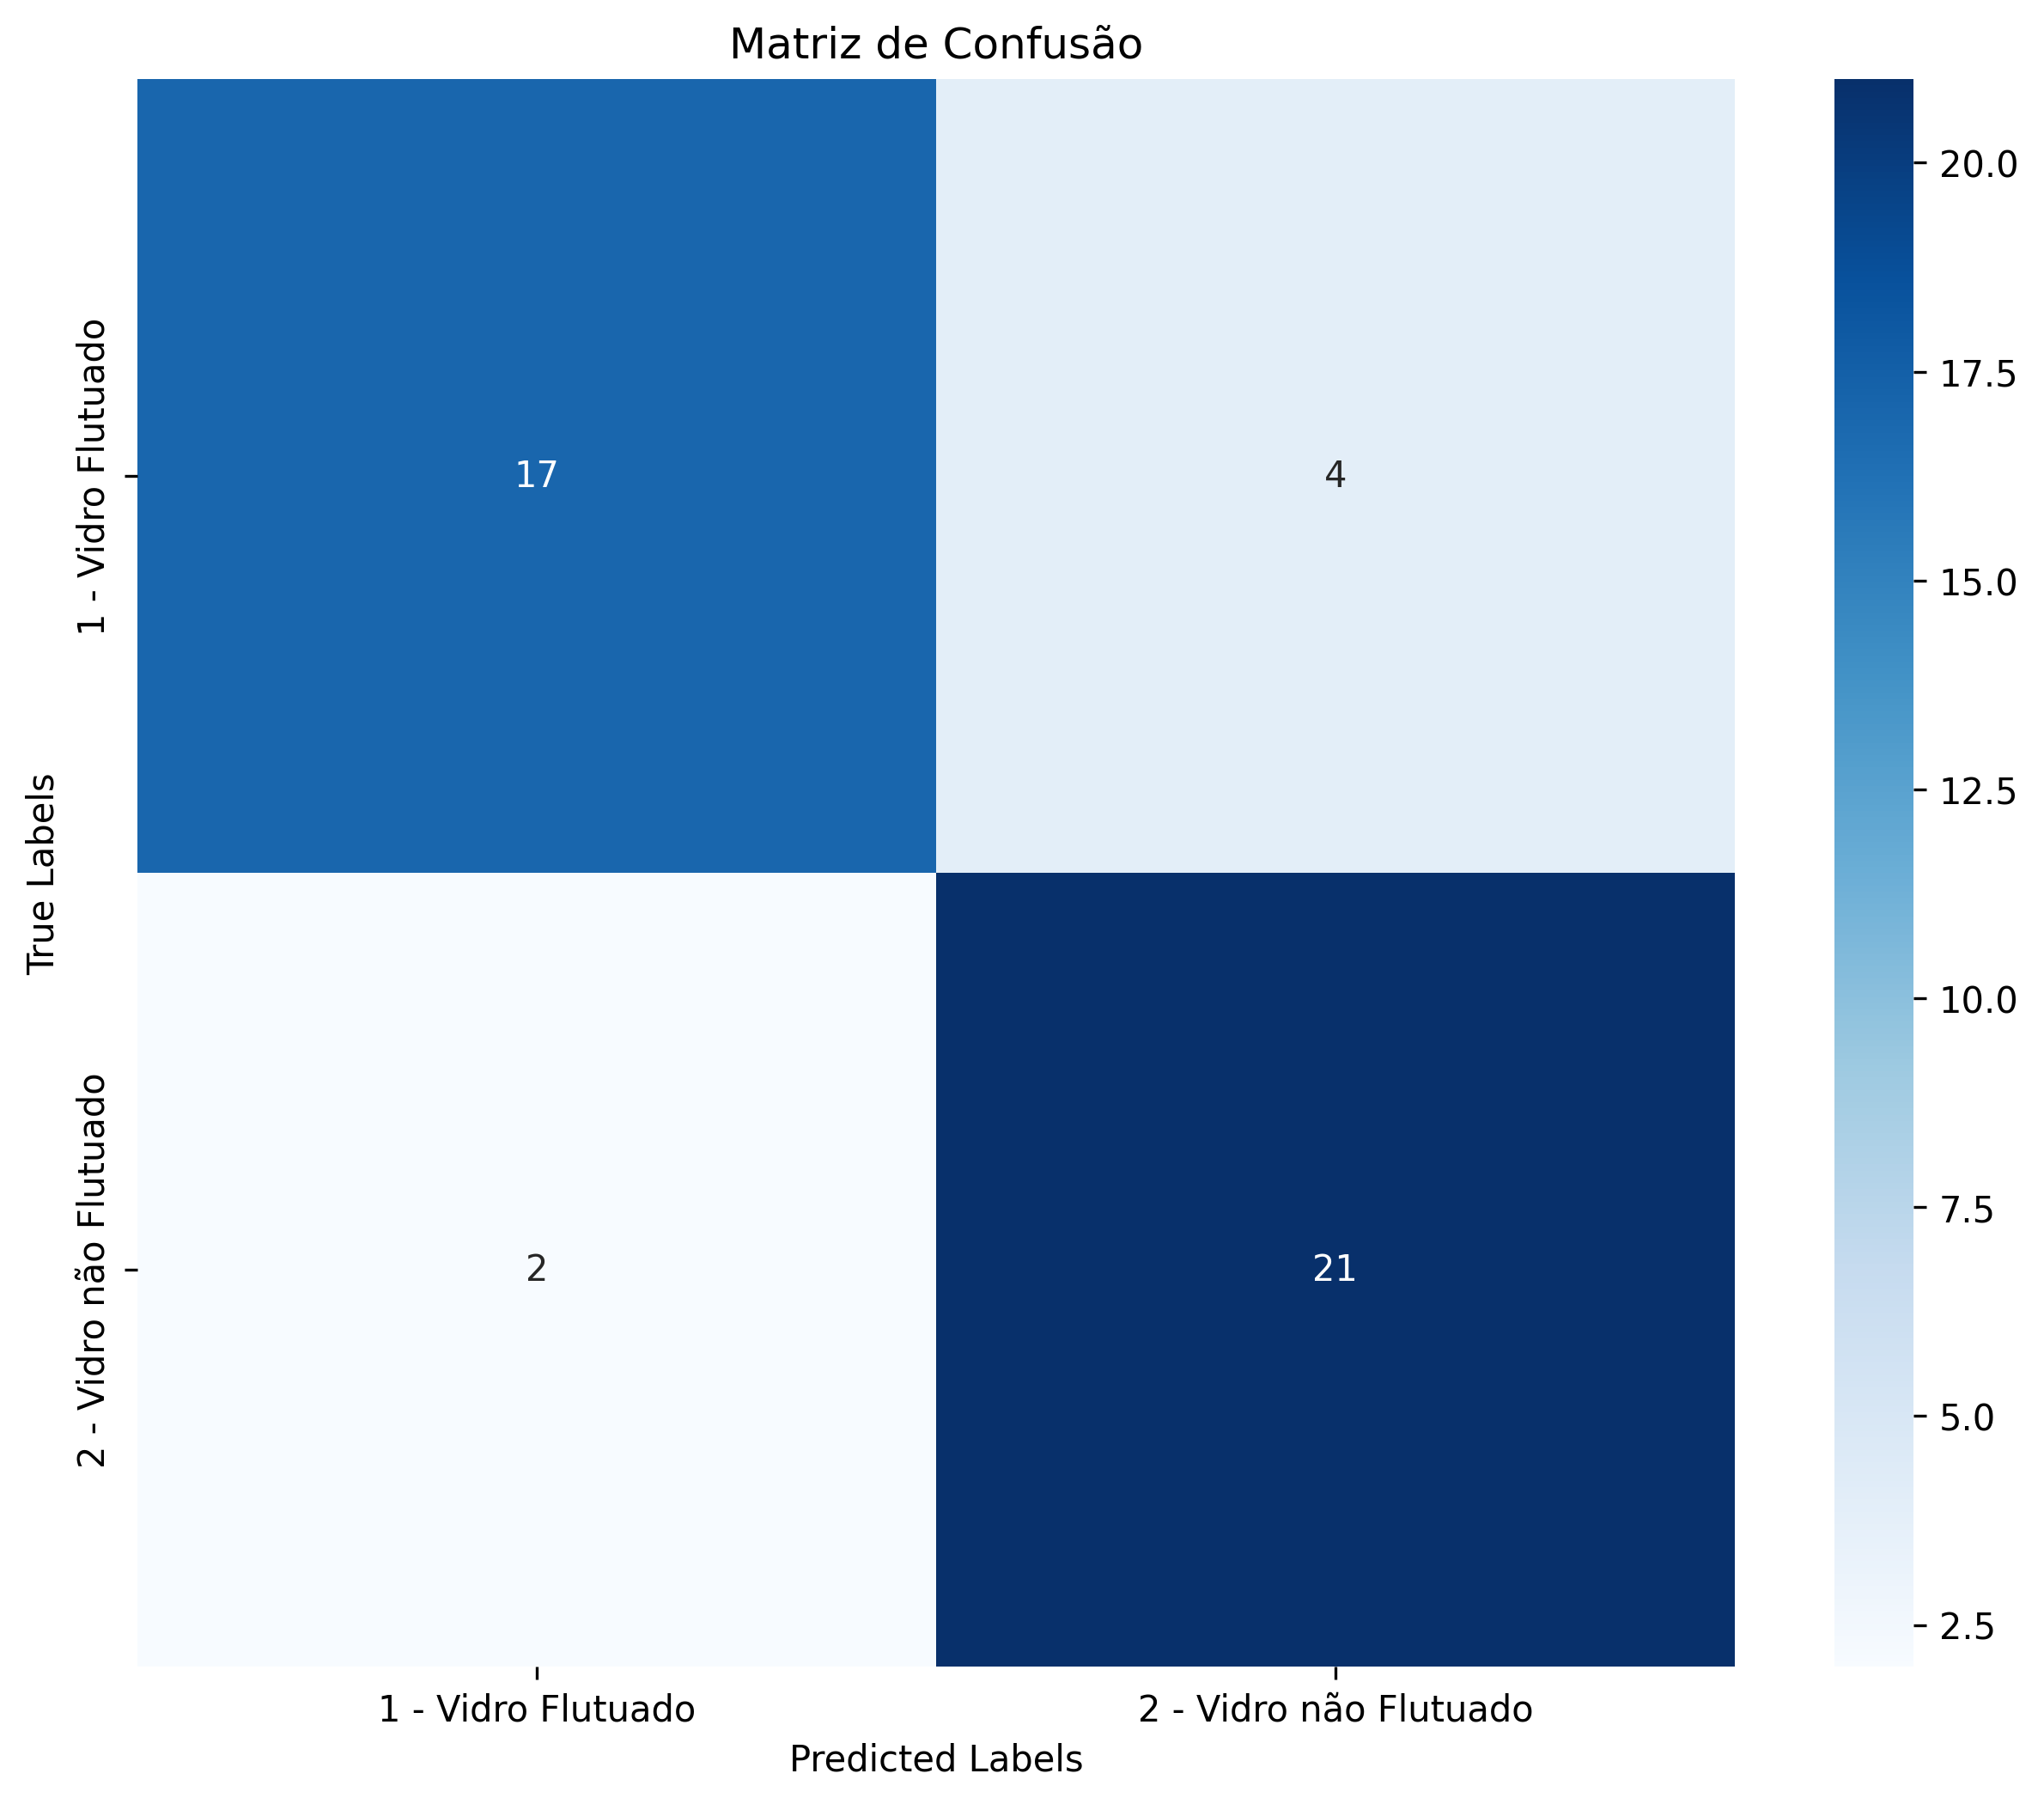

In [36]:
# Gerando a matriz de confusão
conf_matrix = confusion_matrix(y_test, predictions_test)
# Plotando a matriz de confusão
plt.figure(figsize=(10, 8), dpi=dpi)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Matriz de Confusão")
plt.show()

## Hipótese 4 - Juntar 2 Classes (Float e Não Float)

In [37]:
column_names = ["Id", "RI", "Na", "Mg", "Al", "Si", "K", "Ca", "Ba", "Fe", "Tipo"]
df = pd.read_csv('glass.data', names=column_names, index_col="Id")

In [38]:
# Mapeando as classes
df['Tipo'] = df['Tipo'].map({
    1: '1 - Vidro Flutuado', 3: '1 - Vidro Flutuado',
    2: '2 - Vidro Não Flutuado', 4: '2 - Vidro Não Flutuado', 5: '2 - Vidro Não Flutuado', 6: '2 - Vidro Não Flutuado', 7: '2 - Vidro Não Flutuado'
})

In [39]:
# Verificando a contagem de valores únicos em 'Tipo' após o mapeamento
print("Contagem de valores únicos em 'Tipo' após o mapeamento:")
print(df['Tipo'].value_counts())

# Filtrando para manter apenas as linhas onde o 'Tipo' é '1 - Vidro Flutuado' ou '2 - Vidro Temperado'
df = df[df['Tipo'].isin(['1 - Vidro Flutuado', '2 - Vidro Não Flutuado'])]

# Exibindo o DataFrame resultante após o filtro
print("\nDataFrame após remover as linhas com 'Outros':")
print(df)

Contagem de valores únicos em 'Tipo' após o mapeamento:
Tipo
2 - Vidro Não Flutuado    127
1 - Vidro Flutuado         87
Name: count, dtype: int64

DataFrame após remover as linhas com 'Outros':
          RI     Na    Mg    Al     Si     K    Ca    Ba   Fe  \
Id                                                              
1    1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.00  0.0   
2    1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.00  0.0   
3    1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.00  0.0   
4    1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.00  0.0   
5    1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.00  0.0   
..       ...    ...   ...   ...    ...   ...   ...   ...  ...   
210  1.51623  14.14  0.00  2.88  72.61  0.08  9.18  1.06  0.0   
211  1.51685  14.92  0.00  1.99  73.06  0.00  8.40  1.59  0.0   
212  1.52065  14.36  0.00  2.02  73.42  0.00  8.44  1.64  0.0   
213  1.51651  14.38  0.00  1.94  73.61  0.00  8.48  1.57  0.0   
214  1.51711  14.23  0.00

In [40]:
# Separando features e rótulos
X = df.drop(['Tipo', 'Ca'], axis=1).values  # Converte para NumPy diretamente
y = df['Tipo']

In [41]:
# Codificando as classes em valores numéricos
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Normalizando os dados
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [42]:
# Dividindo os dados em treino e teste de forma balanceada (estratificada)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [43]:
# Treinamento do modelo com os parâmetros especificados
model_2CF = NnModel(X_train, y_train, hidden_neurons=32, output_neurons=2)
result_2CF = model_2CF.fit(epochs=4000, lr=0.1, batch_size=10)

Epoch: [400 / 4000]  Accuracy: 0.973 Loss: 0.07287
Epoch: [800 / 4000]  Accuracy: 1.000 Loss: 0.01980
Epoch: [1200 / 4000]  Accuracy: 1.000 Loss: 0.00935
Epoch: [1600 / 4000]  Accuracy: 1.000 Loss: 0.00531
Epoch: [2000 / 4000]  Accuracy: 1.000 Loss: 0.00346
Epoch: [2400 / 4000]  Accuracy: 1.000 Loss: 0.00251
Epoch: [2800 / 4000]  Accuracy: 1.000 Loss: 0.00196
Epoch: [3200 / 4000]  Accuracy: 1.000 Loss: 0.00157
Epoch: [3600 / 4000]  Accuracy: 1.000 Loss: 0.00132
Epoch: [4000 / 4000]  Accuracy: 1.000 Loss: 0.00113

Melhor Acurácia: 1.000 no Epoch 685


In [44]:
# Gerando previsões no conjunto de teste
outputs_test = model_2CF.forward(X_test)
predictions_test = np.argmax(outputs_test, axis=1)

# Gerando o relatório de classificação
print("Relatório de Classificação no Conjunto de Teste:\n")
print(classification_report(y_test, predictions_test))

# Opcional: Exibir acurácia separadamente
accuracy_test = accuracy_score(y_test, predictions_test)
print(f"Acurácia no conjunto de teste: {accuracy_test:.4f}")

Relatório de Classificação no Conjunto de Teste:

              precision    recall  f1-score   support

           0       0.64      0.69      0.67        26
           1       0.78      0.74      0.76        39

    accuracy                           0.72        65
   macro avg       0.71      0.72      0.71        65
weighted avg       0.73      0.72      0.72        65

Acurácia no conjunto de teste: 0.7231


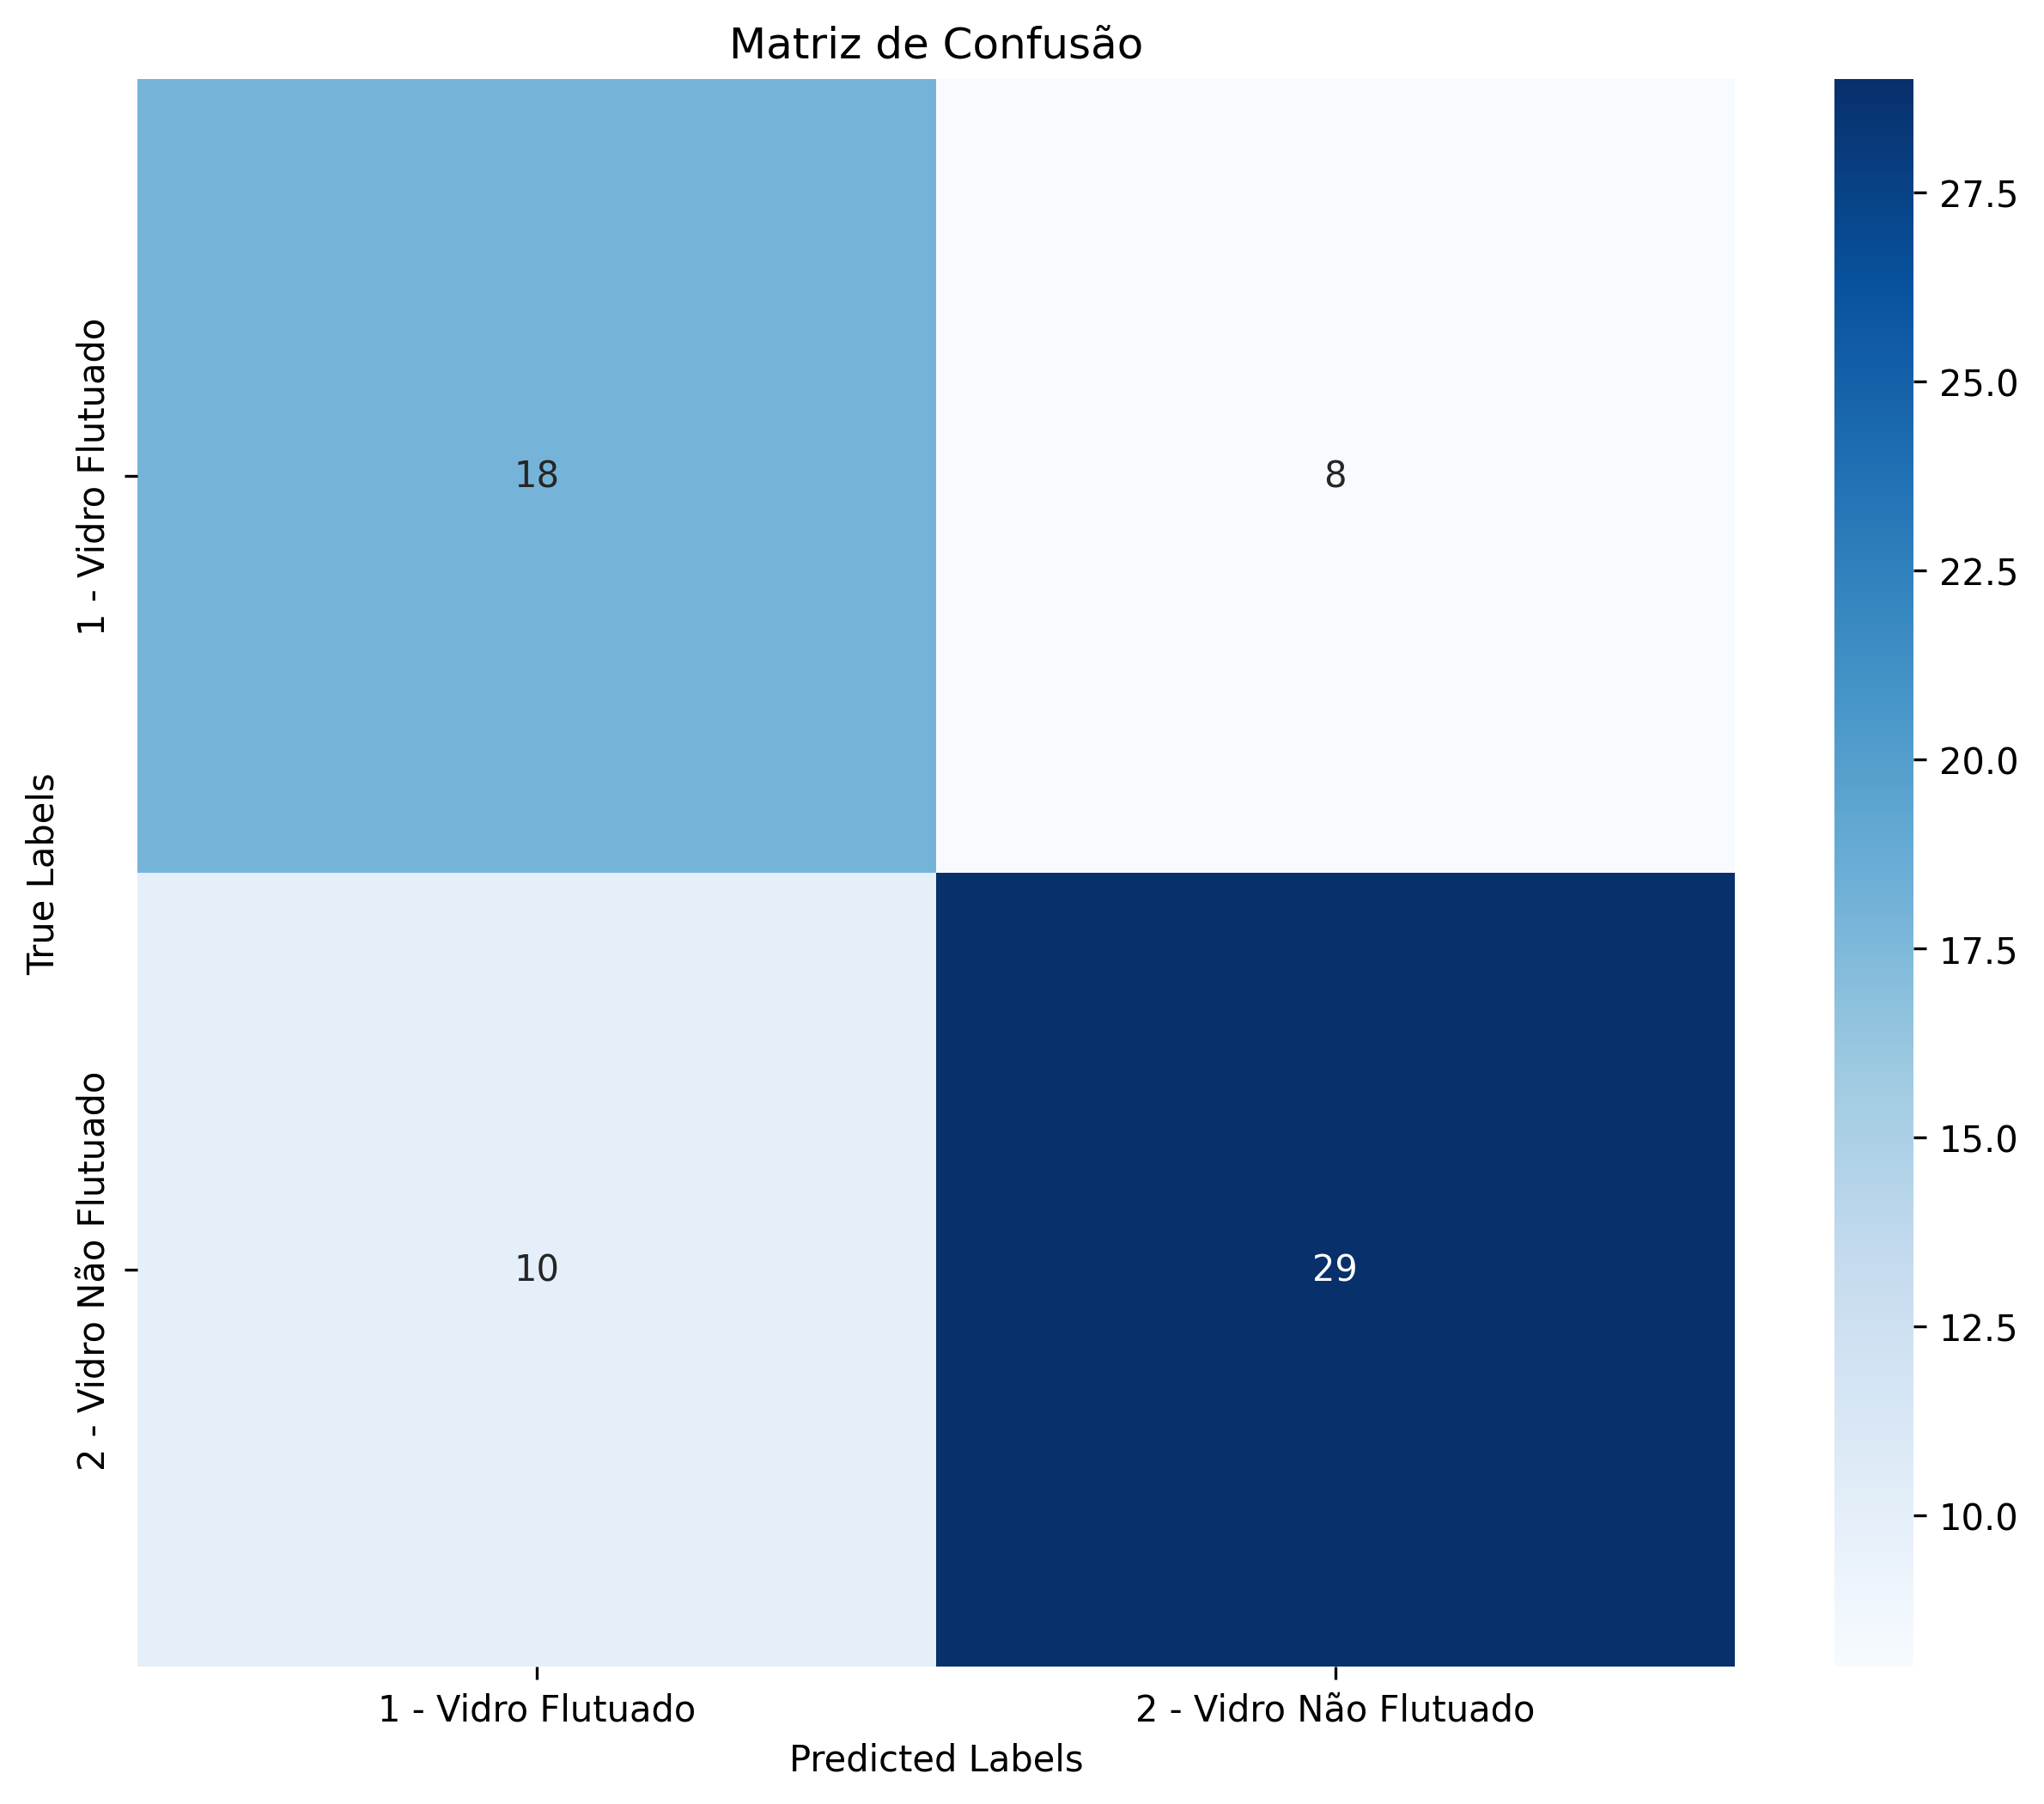

In [45]:
# Gerando a matriz de confusão
conf_matrix = confusion_matrix(y_test, predictions_test)

# Plotando a matriz de confusão
plt.figure(figsize=(10, 8), dpi=dpi)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Matriz de Confusão")
plt.show()

## Hipótese 5 - Todas as 7 Classes e Remover "Ca"

In [46]:
column_names = ["Id", "RI", "Na", "Mg", "Al", "Si", "K", "Ca", "Ba", "Fe", "Tipo"]
df = pd.read_csv('glass.data', names=column_names, index_col="Id")

In [47]:
# Separando features e rótulos
X = df.drop(['Tipo', 'Ca'], axis=1).values
y = df['Tipo']

In [48]:
# Codificando as classes em valores numéricos
encoder = LabelEncoder()
y = encoder.fit_transform(y)

In [49]:
# Normalizando os dados
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [50]:
# Dividindo os dados em treino e teste de forma balanceada (estratificada)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [62]:
# Treinamento do modelo com os parâmetros especificados
model_7CCa = NnModel(X_train, y_train, hidden_neurons=32, output_neurons=7)
result_7CCa = model_7CCa.fit(epochs=800, lr=0.1, batch_size=10)

Epoch: [80 / 800]  Accuracy: 0.872 Loss: 0.37607
Epoch: [160 / 800]  Accuracy: 0.899 Loss: 0.24533
Epoch: [240 / 800]  Accuracy: 0.953 Loss: 0.16282
Epoch: [320 / 800]  Accuracy: 0.966 Loss: 0.11889
Epoch: [400 / 800]  Accuracy: 0.973 Loss: 0.09228
Epoch: [480 / 800]  Accuracy: 0.987 Loss: 0.07297
Epoch: [560 / 800]  Accuracy: 0.987 Loss: 0.06016
Epoch: [640 / 800]  Accuracy: 0.987 Loss: 0.05109
Epoch: [720 / 800]  Accuracy: 0.987 Loss: 0.04241
Epoch: [800 / 800]  Accuracy: 0.993 Loss: 0.03407

Melhor Acurácia: 1.000 no Epoch 628


In [65]:
# Gerando previsões no conjunto de teste
outputs_test = model_7CCa.forward(X_test)
predictions_test = np.argmax(outputs_test, axis=1)

In [66]:
# Gerando o relatório de classificação
print("Relatório de Classificação no Conjunto de Teste:\n")
print(classification_report(y_test, predictions_test))

Relatório de Classificação no Conjunto de Teste:

              precision    recall  f1-score   support

           0       0.68      0.71      0.70        21
           1       0.71      0.74      0.72        23
           2       0.50      0.40      0.44         5
           3       0.33      0.25      0.29         4
           4       0.75      1.00      0.86         3
           5       1.00      0.89      0.94         9

    accuracy                           0.71        65
   macro avg       0.66      0.67      0.66        65
weighted avg       0.70      0.71      0.70        65



In [67]:
# Opcional: Exibir acurácia separadamente
accuracy_test = accuracy_score(y_test, predictions_test)
print(f"Acurácia no conjunto de teste: {accuracy_test:.4f}")

Acurácia no conjunto de teste: 0.7077


In [68]:
# Gerando a matriz de confusão
conf_matrix = confusion_matrix(y_test, predictions_test)

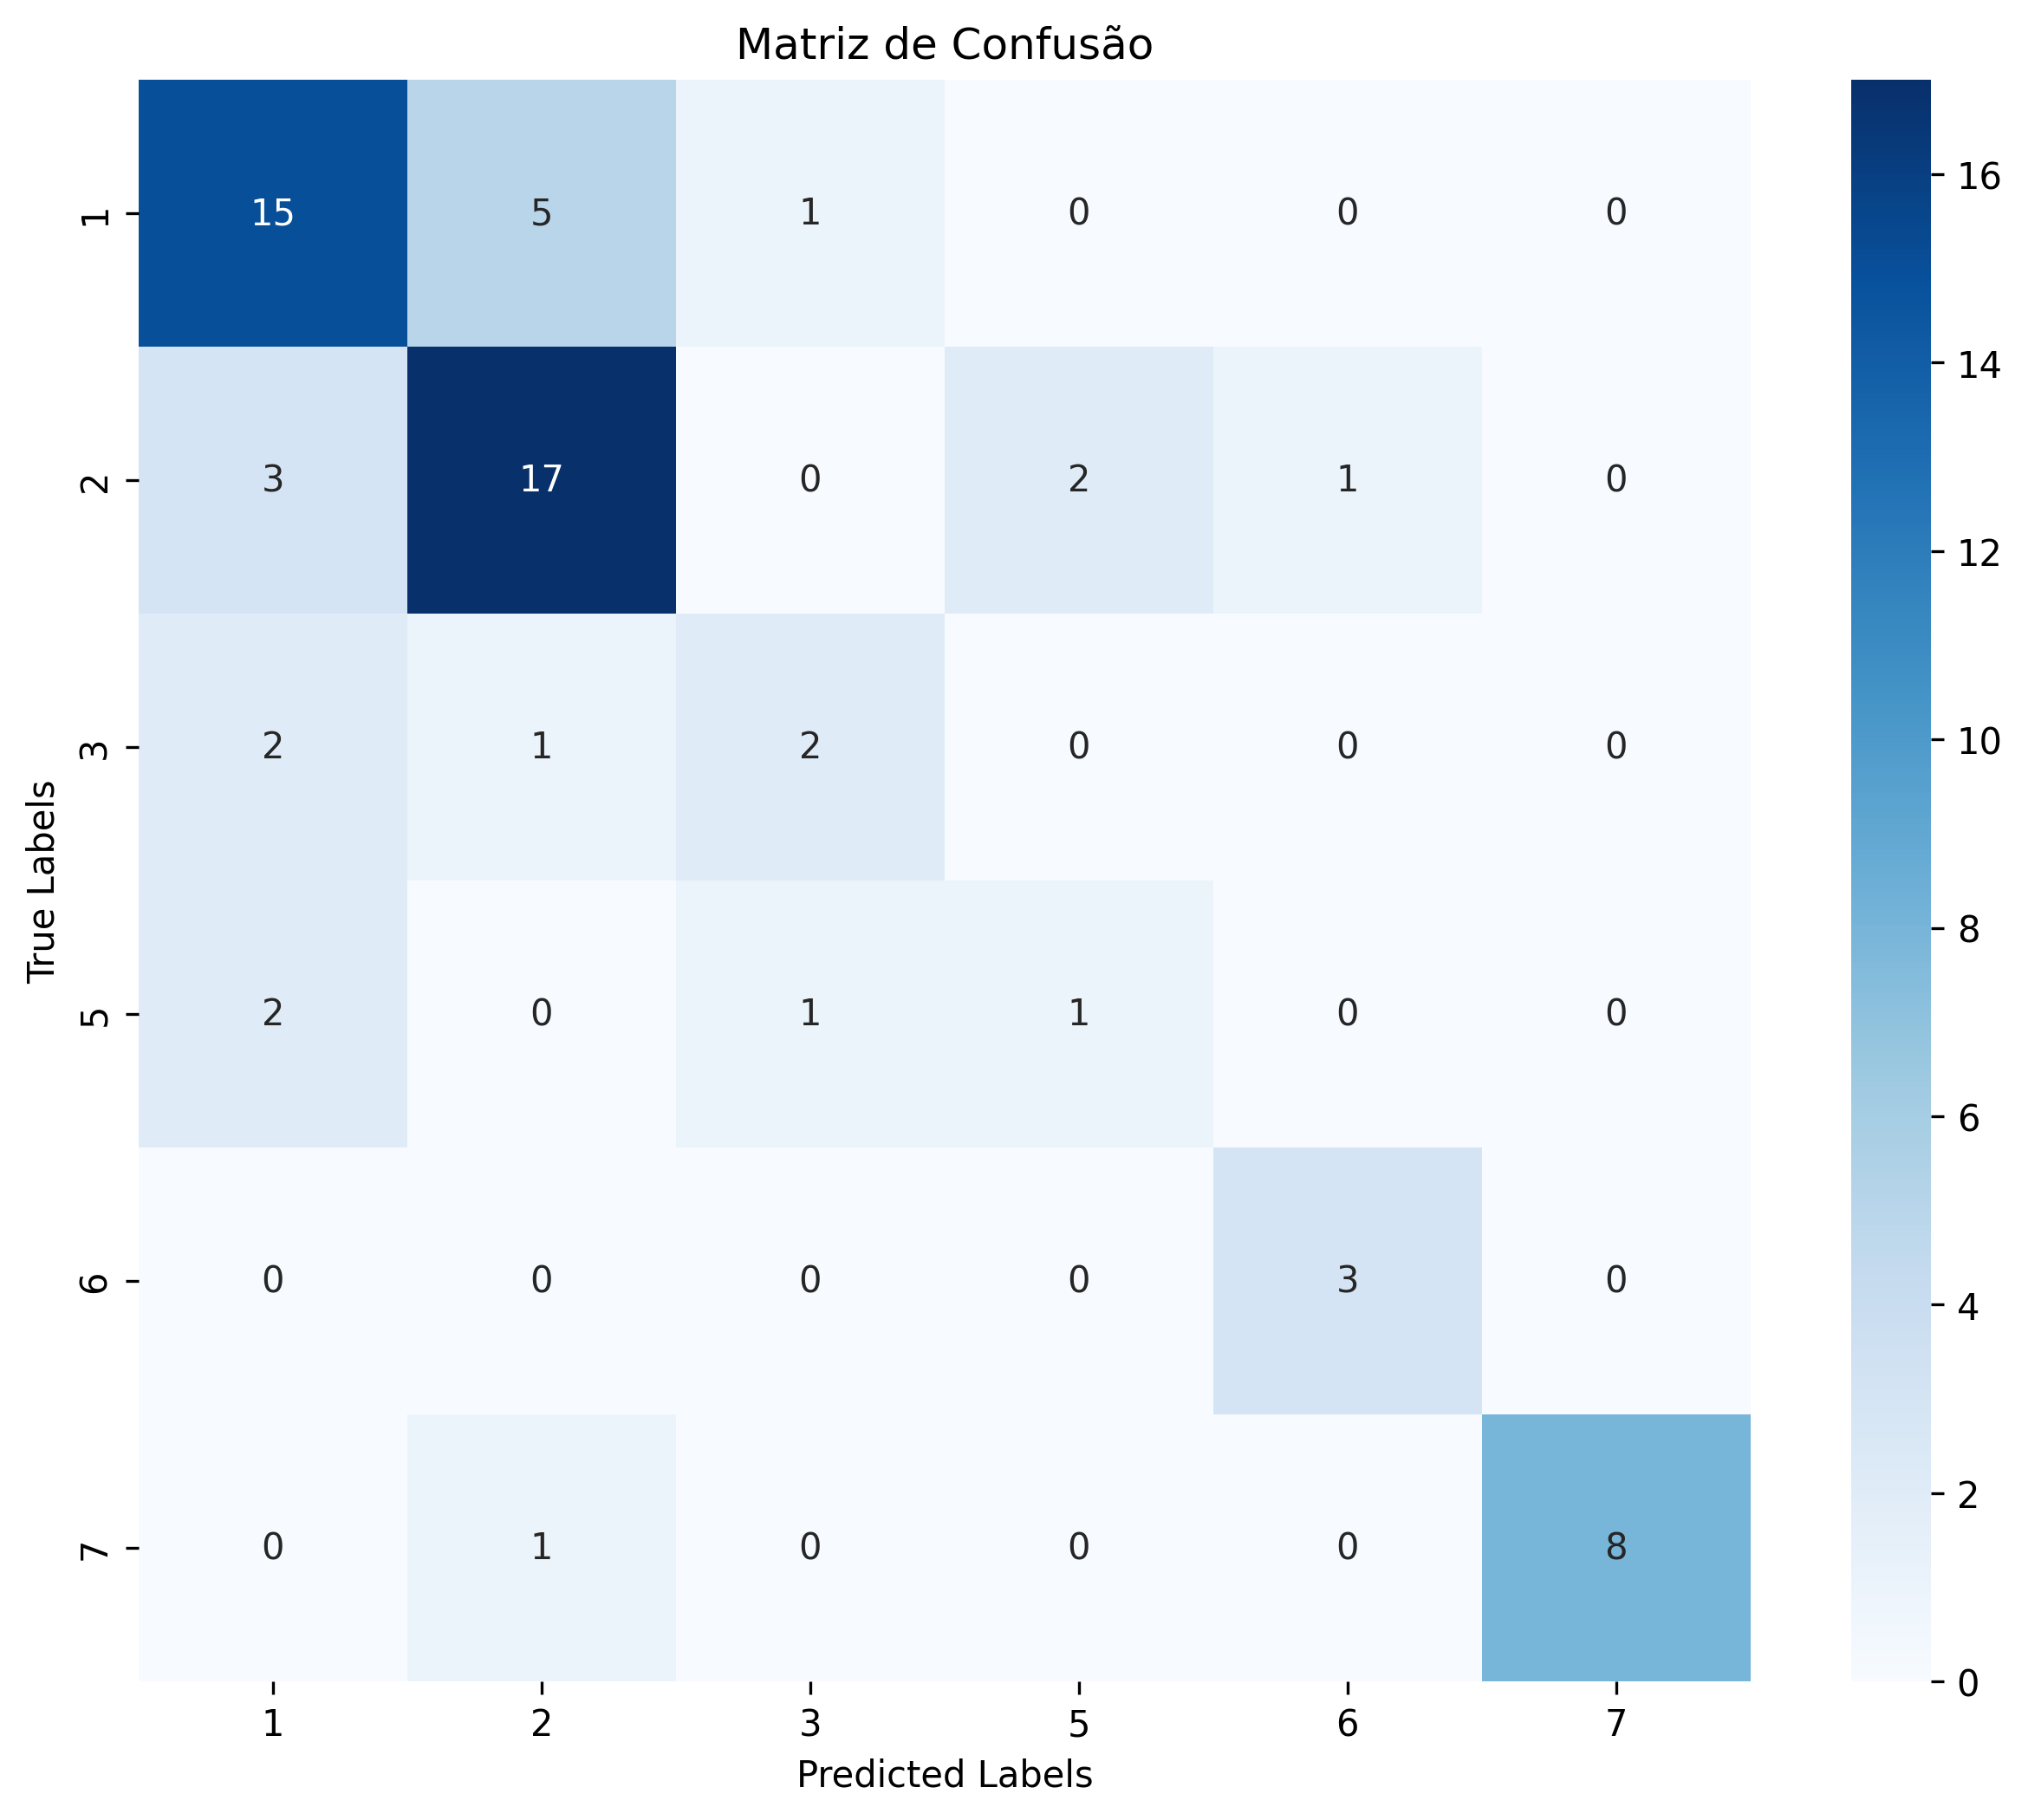

In [69]:
# Plotando a matriz de confusão
plt.figure(figsize=(10, 8), dpi=dpi)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Matriz de Confusão")
plt.show()

# **Resultados**

<p style='text-align: justify;'>
Os resultados obtidos após a aplicação das diferentes hipóteses e ajustes de parâmetros demonstraram variações significativas nas métricas de desempenho.
</p>

# **Conclusão**

<p style='text-align: justify;'>
O estudo confirmou a eficácia de abordagens
</p>
